# A classifier to predict the survival of passengers on The Titanic

Here we will build and evaluate a simple neural net that will aim to predict whether a passenger on the titanic survived based on some simple data provided. The first thing we need to do is load the packages we will need, and the data. This data was provided by kaggle.com.

In [1]:
# Load the packages and modules needed
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf # ML package
from tensorflow import keras # NN object
import matplotlib.pyplot as plt # plotting graphs for evaluation
import random

We have a labelled dataset of 891 passengers indicating the following data:
- Survived: Boolean indicating whether they survived
- Pclass: Takes values in {1,2,3} indicating the class of the ticket
- Name: A string with the passengers name
- Sex: Takes values in {male,female}
- Age: A float giving the age of the passenger in years, to the nearest 0.25 years
- SibSp: An integer giving the number of siblings/spouses aboard
- Parch: An integer giving the number of parents/children aboard
- Ticket: A string giving the ticket number
- Cabin: A string giving the cabin number
- Embarked: Taking values in {C = Cherbourg, Q = Queenstown, S = Southampton} giving the port of embarkation

We also have an unlabelled set of data which we will use to predict survival after we have trained an appropriate neural net.

In [2]:
labelled_data_full = pd.read_csv('titanic_train.csv')
test_data_full = pd.read_csv('test.csv')
test_data_full

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Parsing the data

It is clear that some of the columns will not be important when it comes to determining whether a passenger survived, whereas some will be very important. Some of the data points which seem to be clearly unimportant are:
- Name
- Ticket
- Embarked

On the other hand, the following will likely be very important:
- Pclass
- Sex
- Age
The order for women and children to be rescued first would mean that these classes would be very important in predicting survivability. Also, more of the upper classes were saved than the lower classes. These should all be contained in any NN we build.

The following all seem optional and could be included or not. We will give some arguments for why you might keep them below.
- SibSp: If a passenger had siblings or a spouse on board, perhaps they would have worked harder to ensure the others survived. On the other hand, if they were in a large family perhaps they wouldn't have all fit on a lifeboat and so they had to stay behind. This might be useful information for predicting whether a passenger survived.
- Parch: Children with parents on board would have had someone to take care of them and make sure they got on a lifeboat. This would increase their survival
- Fare: A more expensive fare may indicate a richer individual with more influence and more likely to survive
- Cabin: Perhaps some cabins were closer to the upper decks with the lifeboats whereas others may have been deep below decks. This may have an impact on whether someone survived or not. Unfortunately, very few data entries have a value in Cabin and so we will leave this out of the training data.

We will therefore just take the headings Pclass, Sex, Age, SibSp, Parch, Fare

In [3]:
# Reduce the data to only the columns needed
labelled_reduced_data = labelled_data_full.iloc[:,[1,2,4,5,6,7,9]]
test_data = test_data_full.iloc[:,[1,3,4,5,6,8]]
test_data

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500
414,1,female,39.0,0,0,108.9000
415,3,male,38.5,0,0,7.2500
416,3,male,NaN,0,0,8.0500


A quick analysis shows that some of the ages of the passengers are not present. There are many things that we could do to remedy this, such as remove those data points. Instead, we will replace those NaN values with the average age for that gender and Pclass. The reason that we will do this is that people with Pclass 1 and male are likely to be older than say a Pclass 3 female. Hence, to reflect this in the clean data we will do an average for each group.

First, however, we need to split the data into a traning set and a validation set. We will use 20% of the data for validation meaning that we are splitting the data into a training set of 713, and a validation set of 178. We will take a random sample to avoid bias.

In [4]:
# Create a random split of the data into train and validation sets
rndm_passenger_order = [x for x in range(891)]
random.shuffle(rndm_passenger_order)

# Use the last 178 for the validation set
train_data = labelled_reduced_data.iloc[rndm_passenger_order[:-178],:]
val_data = labelled_reduced_data.iloc[rndm_passenger_order[-178:],:]

# Display the training data
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
53,1,2,female,29.0,1,0,26.0000
107,1,3,male,NaN,0,0,7.7750
582,0,2,male,54.0,0,0,26.0000
142,1,3,female,24.0,1,0,15.8500
514,0,3,male,24.0,0,0,7.4958
...,...,...,...,...,...,...,...
752,0,3,male,33.0,0,0,9.5000
632,1,1,male,32.0,0,0,30.5000
204,1,3,male,18.0,0,0,8.0500
498,0,1,female,25.0,1,2,151.5500


We need to mean-normalise the values so that the optimiser converges well. We will do this for the following headers which have a range >> 1
- age
- fare
- sibsp
- parch

In [5]:
# Mean-normalise by subtracting the mean and dividing by the range

# For the following we will subtract the mean and divide by the range
for header in ['Age','Fare']:
    av = train_data[header].mean()
    range_ = train_data[header].max() - train_data[header].min()
    train_data.loc[:,header] = (train_data.loc[:,header] - av)/range_
#   Implement the same with the validation data
    val_data.loc[:,header] = (val_data.loc[:,header] - av)/range_
    test_data.loc[:,header] = (test_data.loc[:,header] - av)/range_

# For SibSp and Parch we will just divide by the range
# This is so a 0 value remains 0
for header in ['SibSp','Parch']:
    range_ = train_data[header].max() - train_data[header].min()
    train_data.loc[:,header] = train_data.loc[:,header]/range_
#   Implement the same with the validation data
    val_data.loc[:,header] = val_data.loc[:,header]/range_
    test_data.loc[:,header] = test_data.loc[:,header]/range_

train_data

C:\Users\bassg\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
53,1,2,female,-0.010530,0.125,0.000000,-0.009688
107,1,3,male,NaN,0.000,0.000000,-0.045261
582,0,2,male,0.329237,0.000,0.000000,-0.009688
142,1,3,female,-0.078483,0.125,0.000000,-0.029499
514,0,3,male,-0.078483,0.000,0.000000,-0.045806
...,...,...,...,...,...,...,...
752,0,3,male,0.043833,0.000,0.000000,-0.041894
632,1,1,male,0.030242,0.000,0.000000,-0.000904
204,1,3,male,-0.160027,0.000,0.000000,-0.044724
498,0,1,female,-0.064892,0.125,0.333333,0.235369


Now we can clean the data to allow for supervised learning. We will find the average of the age for each group (gender + class) and replace all NaN with the appropriate value

In [6]:
# Isolate all the entries with an age value and without
age_not_null = train_data[pd.notnull(train_data['Age'])]

for pclass in [1,2,3]:
    for sex in ['male','female']:
        # Find the average age
        av_age = age_not_null.loc[
            (age_not_null['Sex'] == sex) &
            (age_not_null['Pclass'] == pclass),
            'Age'].mean()
        # Set any missing values in the training and validation
        train_data.loc[
            (pd.isnull(train_data['Age'])) &
            (train_data['Sex'] == sex) &
            (train_data['Pclass'] == pclass),
            'Age'] = av_age
        val_data.loc[
            (pd.isnull(val_data['Age'])) &
            (val_data['Sex'] == sex) &
            (val_data['Pclass'] == pclass),
            'Age'] = av_age
        test_data.loc[
            (pd.isnull(test_data['Age'])) &
            (test_data['Sex'] == sex) &
            (test_data['Pclass'] == pclass),
            'Age'] = av_age

Finally, I am going to split the headers that fall into certain classes into Boolean values (1,0)

In [7]:
# Find which of the data sets are male, female, and which have Pclass 1,2,3
series_train = []
series_val = []
series_test = []

for sex in ['male','female']:
    # Find the Boolean list on whether male/female
    is_mf_train = (train_data['Sex'] == sex)
    is_mf_val = (val_data['Sex'] == sex)
    is_mf_test = (test_data['Sex'] == sex)
    # Convert into a list of 0,1 and add it to the dataframe
    series_train.append(
         pd.Series(
             data = is_mf_train*1,
             index = is_mf_train.index,
             name = sex
         ))
    series_val.append(
         pd.Series(
             data = is_mf_val*1,
             index = is_mf_val.index,
             name = sex
         ))
    series_test.append(
        pd.Series(
            data = is_mf_test*1,
            index = test_data.index,
            name = sex
        ))
    
for pclass in [1,2,3]:
    # find the Boolean list on whether pclass
    is_pclass_train = (train_data['Pclass'] == pclass)
    is_pclass_val = (val_data['Pclass'] == pclass)
    is_pclass_test = (test_data['Pclass'] == pclass)
    # convert into a list of 0,1
    series_train.append(
        pd.Series(
            data = is_pclass_train*1,
            index = is_pclass_train.index,
            name = 'Pclass' + str(pclass)
        ))
    series_val.append(
        pd.Series(
            data = is_pclass_val*1,
            index = is_pclass_val.index,
            name = 'Pclass' + str(pclass)
        ))
    series_test.append(
        pd.Series(
            data = is_pclass_test*1,
            index = test_data.index,
            name = 'Pclass' + str(pclass)
        ))

# Add the boolean series to the train dataframe
concat_list_train = [train_data]
concat_list_train.extend(series_train)
train_data = pd.concat(concat_list_train,axis = 1)

# Add the boolean series to the val dataframe
concat_list_val = [val_data]
concat_list_val.extend(series_val)
val_data = pd.concat(concat_list_val,axis = 1)

# Add the boolean series to the test dataframe
concat_list_test = [test_data]
concat_list_test.extend(series_test)
test_data = pd.concat(concat_list_test,axis = 1)

We now split the data and the labels for the neural net

In [8]:
# Split into data and labels for train
X_train = train_data.iloc[:,[3,4,5,6,7,8,9,10,11]]
y_train = train_data.iloc[:,0]

# Split into data and labels for val
X_val = val_data.iloc[:,[3,4,5,6,7,8,9,10,11]]
y_val = val_data.iloc[:,0]

# Create the test dataset
X_test = test_data.iloc[:,[2,3,4,5,6,7,8,9,10]]

## The Neural Net 1

We will try our first NN to train on X_train. We will plot the accuracy and the error against that of the validation set to see whether we expect the NN to have high bias/variance. We will also plot the validation accuracy against that of other NN to see which performs best.

The first thing to note is that we don't have a lot of data so we need to be careful that our neural net is not too big. This could lead to a high variance.

Our first NN will just have 1 hidden layer with relu activation. It will be a dense NN meaning that all nodes are connected. It will then lead to a single output node which has a sigmoid activation. We will use the squared error as the loss function.

First we build the model using tensorflow keras, it will initialise the weights. Then we compile the training model and specify the optimising algorithm (which will be adam), the loss function (mean_squared_error), and the metric (accuracy). Then we will fit the model to the data and find a suitable number of epochs to train (around 20)

In [9]:
# Build the first NN with keras
model_1 = keras.Sequential([
    keras.Input(shape = (9,)),
    keras.layers.Dense(18, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

# compile the NN
model_1.compile(optimizer = 'adam',
               loss = 'mean_squared_error',
               metrics = ['accuracy'])

# fit the model to the data
model_1.fit(X_train, y_train, epochs = 50, validation_data = (X_val,y_val))

Epoch 1/50
23/23 [==============================] - 1s 22ms/step - loss: 0.2057 - accuracy: 0.7139 - val_loss: 0.2076 - val_accuracy: 0.6629
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.1910 - accuracy: 0.7602 - val_loss: 0.1945 - val_accuracy: 0.7528
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.1798 - accuracy: 0.7910 - val_loss: 0.1832 - val_accuracy: 0.7809
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.8065 - val_loss: 0.1738 - val_accuracy: 0.7921
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1627 - accuracy: 0.8219 - val_loss: 0.1662 - val_accuracy: 0.8090
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1569 - accuracy: 0.8149 - val_loss: 0.1604 - val_accuracy: 0.7978
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1525 - accuracy: 0.8079 - val_loss: 0.1566 - val_accuracy: 0.7978
Epoch 8/50
23/23 

Next we plot the accuracy and loss for both the X_train and the X_val to determine whether the model fits well and whether we likely have a high bias or a high variance model

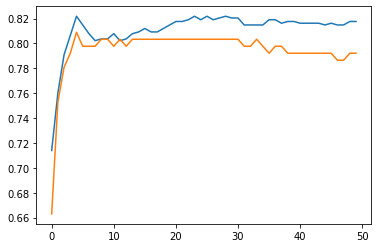

In [10]:
# Plot the accuracy
plt.plot(model_1.history.history['accuracy'])
plt.plot(model_1.history.history['val_accuracy'])

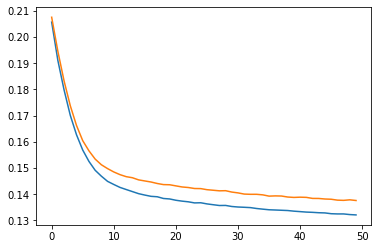

In [11]:
# Plot the loss
plt.plot(model_1.history.history['loss'])
plt.plot(model_1.history.history['val_loss'])

One method of evaluation is to plot the loss as a function of the number of training examples. If there is a large gap between the losses even with a large number of training examples, this suggests a high variance problem. If there is a large error for both the training and validation set then this would suggest a high bias problem.

In [12]:
val_losses_1 = []
train_losses_1 = []
for i in range(1,len(X_train)+1,10):
    # Build the first NN with keras
    model_1 = keras.Sequential([
        keras.Input(shape = (9,)),
        keras.layers.Dense(18, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])

    # compile the NN
    model_1.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['accuracy'])

    # fit the model to the data
    model_1.fit(X_train[:i], y_train[:i], epochs = 50)
    val_losses_1.append(model_1.evaluate(X_val,y_val)[0])
    train_losses_1.append(model_1.evaluate(X_train[:i],y_train[:i])[0])

Epoch 1/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2753 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 1000us/step - loss: 0.2725 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 998us/step - loss: 0.2668 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 999us/step - loss: 0.2640 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 1000us/step - loss: 0.2612 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.2585 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 1000us/step - loss: 0.2557 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 1000us/step - loss: 0.2503 - accu

1/1 [==============================] - 0s 1000us/step - loss: 0.2062 - accuracy: 0.7273
Epoch 33/50
1/1 [==============================] - 0s 999us/step - loss: 0.2054 - accuracy: 0.7273
Epoch 34/50
1/1 [==============================] - 0s 998us/step - loss: 0.2047 - accuracy: 0.7273
Epoch 35/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2039 - accuracy: 0.8182
Epoch 36/50
1/1 [==============================] - 0s 998us/step - loss: 0.2031 - accuracy: 0.8182
Epoch 37/50
1/1 [==============================] - 0s 999us/step - loss: 0.2024 - accuracy: 0.8182
Epoch 38/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2016 - accuracy: 0.8182
Epoch 39/50
1/1 [==============================] - 0s 997us/step - loss: 0.2009 - accuracy: 0.8182
Epoch 40/50
1/1 [==============================] - 0s 1ms/step - loss: 0.2002 - accuracy: 0.8182
Epoch 41/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1994 - accuracy: 0.9091
Epoch 42/50
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2316 - accuracy: 0.6129
Epoch 13/50
1/1 [==============================] - 0s 999us/step - loss: 0.2304 - accuracy: 0.5806
Epoch 14/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2291 - accuracy: 0.6129
Epoch 15/50
1/1 [==============================] - 0s 998us/step - loss: 0.2279 - accuracy: 0.6129
Epoch 16/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.6452
Epoch 17/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2254 - accuracy: 0.7419
Epoch 18/50
1/1 [==============================] - 0s 1000us/step - loss: 0.2242 - accuracy: 0.7097
Epoch 19/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.7097
Epoch 20/50
1/1 [==============================] - 0s 1000us/step - loss: 0.2218 - accuracy: 0.7097
Epoch 21/50
1/1 [==============================] - 0s 999us/step - loss: 0.2206 - accuracy: 0.7097
Epoch 22/50
1/1 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.2174 - accuracy: 0.8293
Epoch 45/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.8293
Epoch 46/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2155 - accuracy: 0.8293
Epoch 47/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.8293
Epoch 48/50
2/2 [==============================] - 0s 999us/step - loss: 0.2136 - accuracy: 0.8293
Epoch 49/50
2/2 [==============================] - 0s 999us/step - loss: 0.2127 - accuracy: 0.8293
Epoch 50/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 0.8293
Epoch 1/50
2/2 [==============================] - 0s 2ms/step - loss: 0.3114 - accuracy: 0.4510
Epoch 2/50
2/2 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.4510
Epoch 3/50
2/2 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.4510
Epoch 4/50
2/2 [=========================

2/2 [==============================] - 0s 996us/step - loss: 0.2346 - accuracy: 0.6066
Epoch 25/50
2/2 [==============================] - 0s 999us/step - loss: 0.2323 - accuracy: 0.6721
Epoch 26/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2301 - accuracy: 0.7049
Epoch 27/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2277 - accuracy: 0.7213
Epoch 28/50
2/2 [==============================] - 0s 2ms/step - loss: 0.2256 - accuracy: 0.7213
Epoch 29/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2232 - accuracy: 0.7213
Epoch 30/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2208 - accuracy: 0.7377
Epoch 31/50
2/2 [==============================] - 0s 996us/step - loss: 0.2184 - accuracy: 0.7541
Epoch 32/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2163 - accuracy: 0.7541
Epoch 33/50
2/2 [==============================] - 0s 999us/step - loss: 0.2140 - accuracy: 0.7541
Epoch 34/50
2/2 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.2823 - accuracy: 0.4074
Epoch 5/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2788 - accuracy: 0.4074
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2756 - accuracy: 0.4074
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.4074
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2692 - accuracy: 0.4074
Epoch 9/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2662 - accuracy: 0.4074
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.4074
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2602 - accuracy: 0.4074
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.4074
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.4074
Epoch 14/50
3/3 [==============================

3/3 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.8242
Epoch 37/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1968 - accuracy: 0.8132
Epoch 38/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1954 - accuracy: 0.8132
Epoch 39/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1939 - accuracy: 0.8132
Epoch 40/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.8132
Epoch 41/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.8132
Epoch 42/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1898 - accuracy: 0.8022
Epoch 43/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1883 - accuracy: 0.8022
Epoch 44/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1871 - accuracy: 0.8022
Epoch 45/50
3/3 [==============================] - 0s 1ms/step - loss: 0.1858 - accuracy: 0.8022
Epoch 46/50
3/3 [=========================

4/4 [==============================] - 0s 1ms/step - loss: 0.2207 - accuracy: 0.6577
Epoch 18/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2185 - accuracy: 0.6667
Epoch 19/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.6757
Epoch 20/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2142 - accuracy: 0.7027
Epoch 21/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2121 - accuracy: 0.7297
Epoch 22/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2100 - accuracy: 0.7477
Epoch 23/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2079 - accuracy: 0.7568
Epoch 24/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2058 - accuracy: 0.7838
Epoch 25/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.7838
Epoch 26/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2017 - accuracy: 0.7838
Epoch 27/50
4/4 [=========================

4/4 [==============================] - 0s 1ms/step - loss: 0.1548 - accuracy: 0.7851
Epoch 50/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1537 - accuracy: 0.7851
Epoch 1/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2891 - accuracy: 0.3206
Epoch 2/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2843 - accuracy: 0.3206
Epoch 3/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2803 - accuracy: 0.3282
Epoch 4/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2762 - accuracy: 0.3359
Epoch 5/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2723 - accuracy: 0.3359
Epoch 6/50
5/5 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.3435
Epoch 7/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2647 - accuracy: 0.3435
Epoch 8/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2612 - accuracy: 0.3435
Epoch 9/50
5/5 [==============================] - 

5/5 [==============================] - 0s 1ms/step - loss: 0.1509 - accuracy: 0.8227
Epoch 31/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1498 - accuracy: 0.8227
Epoch 32/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1487 - accuracy: 0.8156
Epoch 33/50
5/5 [==============================] - 0s 999us/step - loss: 0.1477 - accuracy: 0.8156
Epoch 34/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1467 - accuracy: 0.8156
Epoch 35/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1458 - accuracy: 0.8156
Epoch 36/50
5/5 [==============================] - 0s 1000us/step - loss: 0.1449 - accuracy: 0.8156
Epoch 37/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1442 - accuracy: 0.8227
Epoch 38/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1435 - accuracy: 0.8227
Epoch 39/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1427 - accuracy: 0.8227
Epoch 40/50
5/5 [====================

6/6 [==============================] - 0s 999us/step - loss: 0.2169 - accuracy: 0.6957
Epoch 12/50
6/6 [==============================] - 0s 1ms/step - loss: 0.2133 - accuracy: 0.6957
Epoch 13/50
6/6 [==============================] - 0s 1ms/step - loss: 0.2092 - accuracy: 0.6957
Epoch 14/50
6/6 [==============================] - 0s 1ms/step - loss: 0.2061 - accuracy: 0.7081
Epoch 15/50
6/6 [==============================] - 0s 1ms/step - loss: 0.2030 - accuracy: 0.7329
Epoch 16/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1999 - accuracy: 0.7578
Epoch 17/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1964 - accuracy: 0.7826
Epoch 18/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1936 - accuracy: 0.8012
Epoch 19/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1910 - accuracy: 0.8323
Epoch 20/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 0.8323
Epoch 21/50
6/6 [=======================

Epoch 43/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1499 - accuracy: 0.7895
Epoch 44/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1491 - accuracy: 0.7895
Epoch 45/50
6/6 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.7895
Epoch 46/50
6/6 [==============================] - 0s 2ms/step - loss: 0.1478 - accuracy: 0.7895
Epoch 47/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1473 - accuracy: 0.7895
Epoch 48/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1468 - accuracy: 0.7895
Epoch 49/50
6/6 [==============================] - 0s 2ms/step - loss: 0.1462 - accuracy: 0.7895
Epoch 50/50
6/6 [==============================] - 0s 998us/step - loss: 0.1454 - accuracy: 0.7953
Epoch 1/50
6/6 [==============================] - 0s 1ms/step - loss: 0.2402 - accuracy: 0.6575
Epoch 2/50
6/6 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.6906
Epoch 3/50
6/6 [==============

6/6 [==============================] - 0s 1ms/step - loss: 0.1967 - accuracy: 0.7120
Epoch 24/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1947 - accuracy: 0.7120
Epoch 25/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.7173
Epoch 26/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1906 - accuracy: 0.7173
Epoch 27/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1884 - accuracy: 0.7173
Epoch 28/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1865 - accuracy: 0.7173
Epoch 29/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1843 - accuracy: 0.7173
Epoch 30/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1823 - accuracy: 0.7330
Epoch 31/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1801 - accuracy: 0.7487
Epoch 32/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.7644
Epoch 33/50
6/6 [=========================

7/7 [==============================] - 0s 1ms/step - loss: 0.2263 - accuracy: 0.7014
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2217 - accuracy: 0.7014
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2167 - accuracy: 0.7014
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2124 - accuracy: 0.7109
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.7109
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2049 - accuracy: 0.7109
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2015 - accuracy: 0.7109
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1982 - accuracy: 0.7109
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1953 - accuracy: 0.7109
Epoch 12/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1923 - accuracy: 0.7109
Epoch 13/50
7/7 [==============================]

7/7 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.8009
Epoch 36/50
7/7 [==============================] - 0s 999us/step - loss: 0.1452 - accuracy: 0.8009
Epoch 37/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1444 - accuracy: 0.8009
Epoch 38/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1438 - accuracy: 0.8054
Epoch 39/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1432 - accuracy: 0.8054
Epoch 40/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1425 - accuracy: 0.8054
Epoch 41/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.8054
Epoch 42/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1414 - accuracy: 0.8054
Epoch 43/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1409 - accuracy: 0.8054
Epoch 44/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1404 - accuracy: 0.8054
Epoch 45/50
7/7 [=======================

8/8 [==============================] - 0s 1ms/step - loss: 0.1959 - accuracy: 0.8008
Epoch 16/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1921 - accuracy: 0.8008
Epoch 17/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1882 - accuracy: 0.8008
Epoch 18/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1846 - accuracy: 0.8008
Epoch 19/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.8008
Epoch 20/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 0.8050
Epoch 21/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1726 - accuracy: 0.8091
Epoch 22/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1691 - accuracy: 0.8133
Epoch 23/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1660 - accuracy: 0.8133
Epoch 24/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1631 - accuracy: 0.8133
Epoch 25/50
8/8 [=========================

8/8 [==============================] - 0s 1ms/step - loss: 0.1481 - accuracy: 0.7888
Epoch 48/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1473 - accuracy: 0.7928
Epoch 49/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1467 - accuracy: 0.7928
Epoch 50/50
8/8 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.7928
Epoch 1/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2616 - accuracy: 0.3295
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2527 - accuracy: 0.5134
Epoch 3/50
9/9 [==============================] - 0s 999us/step - loss: 0.2443 - accuracy: 0.6513
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2369 - accuracy: 0.6513
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2300 - accuracy: 0.6475
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2236 - accuracy: 0.6705
Epoch 7/50
9/9 [==============================

9/9 [==============================] - 0s 1ms/step - loss: 0.1505 - accuracy: 0.8044
Epoch 28/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1496 - accuracy: 0.8081
Epoch 29/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1487 - accuracy: 0.8081
Epoch 30/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1479 - accuracy: 0.8081
Epoch 31/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1471 - accuracy: 0.8081
Epoch 32/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1466 - accuracy: 0.8081
Epoch 33/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.8081
Epoch 34/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1454 - accuracy: 0.8118
Epoch 35/50
9/9 [==============================] - 0s 999us/step - loss: 0.1447 - accuracy: 0.8118
Epoch 36/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.8081
Epoch 37/50
9/9 [=======================

10/10 [==============================] - 0s 999us/step - loss: 0.2319 - accuracy: 0.6254
Epoch 8/50
10/10 [==============================] - 0s 1ms/step - loss: 0.2255 - accuracy: 0.6254
Epoch 9/50
10/10 [==============================] - 0s 999us/step - loss: 0.2195 - accuracy: 0.6254
Epoch 10/50
10/10 [==============================] - 0s 1ms/step - loss: 0.2134 - accuracy: 0.6254
Epoch 11/50
10/10 [==============================] - 0s 1ms/step - loss: 0.2078 - accuracy: 0.6254
Epoch 12/50
10/10 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.6495
Epoch 13/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1973 - accuracy: 0.7354
Epoch 14/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1927 - accuracy: 0.7835
Epoch 15/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1881 - accuracy: 0.7904
Epoch 16/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1837 - accuracy: 0.7904
Epoch 17/50
10/10 [=

10/10 [==============================] - 0s 1ms/step - loss: 0.1411 - accuracy: 0.8173
Epoch 39/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1407 - accuracy: 0.8206
Epoch 40/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1402 - accuracy: 0.8206
Epoch 41/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.8173
Epoch 42/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1397 - accuracy: 0.8140
Epoch 43/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1393 - accuracy: 0.8206
Epoch 44/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.8206
Epoch 45/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.8173
Epoch 46/50
10/10 [==============================] - 0s 999us/step - loss: 0.1385 - accuracy: 0.8173
Epoch 47/50
10/10 [==============================] - 0s 1ms/step - loss: 0.1382 - accuracy: 0.8140
Epoch 48/50
10/10 [=

11/11 [==============================] - 0s 1ms/step - loss: 0.1647 - accuracy: 0.7788
Epoch 18/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1638 - accuracy: 0.7788
Epoch 19/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1626 - accuracy: 0.7819
Epoch 20/50
11/11 [==============================] - 0s 999us/step - loss: 0.1615 - accuracy: 0.7850
Epoch 21/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1604 - accuracy: 0.7913
Epoch 22/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1595 - accuracy: 0.7944
Epoch 23/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1585 - accuracy: 0.7944
Epoch 24/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1576 - accuracy: 0.7913
Epoch 25/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1568 - accuracy: 0.7913
Epoch 26/50
11/11 [==============================] - 0s 999us/step - loss: 0.1559 - accuracy: 0.7944
Epoch 27/50
11/11 

11/11 [==============================] - 0s 1ms/step - loss: 0.1403 - accuracy: 0.8097
Epoch 48/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.8127
Epoch 49/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1397 - accuracy: 0.8097
Epoch 50/50
11/11 [==============================] - 0s 909us/step - loss: 0.1392 - accuracy: 0.8127
Epoch 1/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1841 - accuracy: 0.7889
Epoch 2/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.7889
Epoch 3/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1739 - accuracy: 0.7889
Epoch 4/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1695 - accuracy: 0.7889
Epoch 5/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1660 - accuracy: 0.7918
Epoch 6/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1632 - accuracy: 0.7889
Epoch 7/50
11/11 [========

11/11 [==============================] - 0s 1ms/step - loss: 0.1506 - accuracy: 0.7977
Epoch 27/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1495 - accuracy: 0.7949
Epoch 28/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1485 - accuracy: 0.7949
Epoch 29/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1477 - accuracy: 0.7892
Epoch 30/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1469 - accuracy: 0.7920
Epoch 31/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1461 - accuracy: 0.7920
Epoch 32/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1454 - accuracy: 0.7920
Epoch 33/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1448 - accuracy: 0.7920
Epoch 34/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.7920
Epoch 35/50
11/11 [==============================] - 0s 1ms/step - loss: 0.1438 - accuracy: 0.7920
Epoch 36/50
11/11 [===

12/12 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.6792
Epoch 6/50
12/12 [==============================] - 0s 1ms/step - loss: 0.2054 - accuracy: 0.7251
Epoch 7/50
12/12 [==============================] - 0s 1ms/step - loss: 0.2001 - accuracy: 0.7278
Epoch 8/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1951 - accuracy: 0.7709
Epoch 9/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1905 - accuracy: 0.7925
Epoch 10/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1865 - accuracy: 0.7925
Epoch 11/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1824 - accuracy: 0.7925
Epoch 12/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1786 - accuracy: 0.7925
Epoch 13/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1753 - accuracy: 0.7925
Epoch 14/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1720 - accuracy: 0.7925
Epoch 15/50
12/12 [=======

12/12 [==============================] - 0s 1ms/step - loss: 0.1378 - accuracy: 0.8136
Epoch 37/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1374 - accuracy: 0.8163
Epoch 38/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.8189
Epoch 39/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8163
Epoch 40/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1367 - accuracy: 0.8163
Epoch 41/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1364 - accuracy: 0.8163
Epoch 42/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.8163
Epoch 43/50
12/12 [==============================] - 0s 1ms/step - loss: 0.1360 - accuracy: 0.8189
Epoch 44/50
12/12 [==============================] - 0s 999us/step - loss: 0.1357 - accuracy: 0.8189
Epoch 45/50
12/12 [==============================] - 0s 1000us/step - loss: 0.1356 - accuracy: 0.8215
Epoch 46/50
12/12

13/13 [==============================] - 0s 1ms/step - loss: 0.1638 - accuracy: 0.8005
Epoch 16/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1612 - accuracy: 0.7980
Epoch 17/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1585 - accuracy: 0.7980
Epoch 18/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1561 - accuracy: 0.7980
Epoch 19/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1540 - accuracy: 0.8080
Epoch 20/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1520 - accuracy: 0.8204
Epoch 21/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1502 - accuracy: 0.8204
Epoch 22/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1485 - accuracy: 0.8130
Epoch 23/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1469 - accuracy: 0.8130
Epoch 24/50
13/13 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.8155
Epoch 25/50
13/13 [===

13/13 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.8248
Epoch 46/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.8273
Epoch 47/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1309 - accuracy: 0.8273
Epoch 48/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.8273
Epoch 49/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.8248
Epoch 50/50
13/13 [==============================] - 0s 924us/step - loss: 0.1299 - accuracy: 0.8248
Epoch 1/50
14/14 [==============================] - 0s 1ms/step - loss: 0.2202 - accuracy: 0.6295
Epoch 2/50
14/14 [==============================] - 0s 1ms/step - loss: 0.2107 - accuracy: 0.6437
Epoch 3/50
14/14 [==============================] - 0s 1ms/step - loss: 0.2029 - accuracy: 0.6722
Epoch 4/50
14/14 [==============================] - 0s 1ms/step - loss: 0.1960 - accuracy: 0.7173
Epoch 5/50
14/14 [======

14/14 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.8005
Epoch 25/50
14/14 [==============================] - 0s 1ms/step - loss: 0.1396 - accuracy: 0.7981
Epoch 26/50
14/14 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.8028
Epoch 27/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.8028
Epoch 28/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1381 - accuracy: 0.8028
Epoch 29/50
14/14 [==============================] - 0s 1ms/step - loss: 0.1377 - accuracy: 0.8051
Epoch 30/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.8051
Epoch 31/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1368 - accuracy: 0.8051
Epoch 32/50
14/14 [==============================] - 0s 1ms/step - loss: 0.1364 - accuracy: 0.8051
Epoch 33/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1361 - accuracy: 0.8051
Epoch 34/50
14/14 [===

15/15 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.6386
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.6608
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.7228
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.7494
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.7894
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.1943 - accuracy: 0.7960
Epoch 9/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1871 - accuracy: 0.8004
Epoch 10/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1803 - accuracy: 0.8027
Epoch 11/50
15/15 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.8027
Epoch 12/50
15/15 [==============================] - 0s 2ms/step - loss: 0.1690 - accuracy: 0.8027
Epoch 13/50
15/15 [=========

15/15 [==============================] - 0s 1ms/step - loss: 0.1396 - accuracy: 0.8069
Epoch 35/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1393 - accuracy: 0.8026
Epoch 36/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.8069
Epoch 37/50
15/15 [==============================] - 0s 999us/step - loss: 0.1384 - accuracy: 0.8091
Epoch 38/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1382 - accuracy: 0.8048
Epoch 39/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1379 - accuracy: 0.8069
Epoch 40/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.8113
Epoch 41/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1373 - accuracy: 0.8091
Epoch 42/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.8091
Epoch 43/50
15/15 [==============================] - 0s 1ms/step - loss: 0.1367 - accuracy: 0.8091
Epoch 44/50
15/15 [=

16/16 [==============================] - 0s 1ms/step - loss: 0.1598 - accuracy: 0.7921
Epoch 14/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.7921
Epoch 15/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1540 - accuracy: 0.8004
Epoch 16/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1520 - accuracy: 0.7900
Epoch 17/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1503 - accuracy: 0.7963
Epoch 18/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1487 - accuracy: 0.7983
Epoch 19/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1475 - accuracy: 0.7942
Epoch 20/50
16/16 [==============================] - 0s 999us/step - loss: 0.1467 - accuracy: 0.7921
Epoch 21/50
16/16 [==============================] - 0s 999us/step - loss: 0.1462 - accuracy: 0.7921
Epoch 22/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1451 - accuracy: 0.7921
Epoch 23/50
16/16 

16/16 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8228
Epoch 44/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.8228
Epoch 45/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.8228
Epoch 46/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8208
Epoch 47/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8228
Epoch 48/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1293 - accuracy: 0.8248
Epoch 49/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.8248
Epoch 50/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1288 - accuracy: 0.8208
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2664 - accuracy: 0.3733
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2448 - accuracy: 0.4132
Epoch 3/50
16/16 [======

Epoch 22/50
16/16 [==============================] - 0s 999us/step - loss: 0.1416 - accuracy: 0.8043
Epoch 23/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1409 - accuracy: 0.8023
Epoch 24/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1401 - accuracy: 0.8043
Epoch 25/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1394 - accuracy: 0.8043
Epoch 26/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.8063
Epoch 27/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.8043
Epoch 28/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1378 - accuracy: 0.8082
Epoch 29/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1375 - accuracy: 0.8082
Epoch 30/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.8082
Epoch 31/50
16/16 [==============================] - 0s 999us/step - loss: 0.1367 - accuracy: 0.8082
Epoch 

17/17 [==============================] - 0s 882us/step - loss: 0.1298 - accuracy: 0.8177
Epoch 1/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3270 - accuracy: 0.3032
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3013 - accuracy: 0.3145
Epoch 3/50
17/17 [==============================] - 0s 999us/step - loss: 0.2798 - accuracy: 0.4030
Epoch 4/50
17/17 [==============================] - 0s 999us/step - loss: 0.2629 - accuracy: 0.5913
Epoch 5/50
17/17 [==============================] - 0s 1000us/step - loss: 0.2491 - accuracy: 0.6083
Epoch 6/50
17/17 [==============================] - 0s 999us/step - loss: 0.2378 - accuracy: 0.6064
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2291 - accuracy: 0.5989
Epoch 8/50
17/17 [==============================] - 0s 1000us/step - loss: 0.2206 - accuracy: 0.6403
Epoch 9/50
17/17 [==============================] - 0s 941us/step - loss: 0.2135 - accuracy: 0.6911
Epoch 10/50
17/

17/17 [==============================] - 0s 940us/step - loss: 0.1349 - accuracy: 0.8189
Epoch 31/50
17/17 [==============================] - 0s 940us/step - loss: 0.1345 - accuracy: 0.8189
Epoch 32/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.8207
Epoch 33/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.8207
Epoch 34/50
17/17 [==============================] - 0s 1000us/step - loss: 0.1336 - accuracy: 0.8170
Epoch 35/50
17/17 [==============================] - 0s 999us/step - loss: 0.1332 - accuracy: 0.8207
Epoch 36/50
17/17 [==============================] - 0s 996us/step - loss: 0.1330 - accuracy: 0.8207
Epoch 37/50
17/17 [==============================] - 0s 941us/step - loss: 0.1327 - accuracy: 0.8207
Epoch 38/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.8189
Epoch 39/50
17/17 [==============================] - 0s 1000us/step - loss: 0.1322 - accuracy: 0.8207
Epoch 

18/18 [==============================] - 0s 999us/step - loss: 0.1598 - accuracy: 0.7968
Epoch 9/50
18/18 [==============================] - 0s 999us/step - loss: 0.1564 - accuracy: 0.7986
Epoch 10/50
18/18 [==============================] - 0s 999us/step - loss: 0.1535 - accuracy: 0.8021
Epoch 11/50
18/18 [==============================] - 0s 1ms/step - loss: 0.1512 - accuracy: 0.8021
Epoch 12/50
18/18 [==============================] - 0s 1ms/step - loss: 0.1492 - accuracy: 0.8021
Epoch 13/50
18/18 [==============================] - 0s 1000us/step - loss: 0.1475 - accuracy: 0.8021
Epoch 14/50
18/18 [==============================] - 0s 1ms/step - loss: 0.1460 - accuracy: 0.8021
Epoch 15/50
18/18 [==============================] - 0s 1000us/step - loss: 0.1448 - accuracy: 0.8021
Epoch 16/50
18/18 [==============================] - 0s 1ms/step - loss: 0.1436 - accuracy: 0.8021
Epoch 17/50
18/18 [==============================] - 0s 999us/step - loss: 0.1426 - accuracy: 0.8021
Epoch 18/

18/18 [==============================] - 0s 999us/step - loss: 0.1328 - accuracy: 0.8144
Epoch 39/50
18/18 [==============================] - 0s 999us/step - loss: 0.1328 - accuracy: 0.8161
Epoch 40/50
18/18 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.8109
Epoch 41/50
18/18 [==============================] - 0s 999us/step - loss: 0.1323 - accuracy: 0.8144
Epoch 42/50
18/18 [==============================] - 0s 999us/step - loss: 0.1321 - accuracy: 0.8144
Epoch 43/50
18/18 [==============================] - 0s 1000us/step - loss: 0.1320 - accuracy: 0.8109
Epoch 44/50
18/18 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.8144
Epoch 45/50
18/18 [==============================] - 0s 999us/step - loss: 0.1316 - accuracy: 0.8161
Epoch 46/50
18/18 [==============================] - 0s 999us/step - loss: 0.1316 - accuracy: 0.8144
Epoch 47/50
18/18 [==============================] - 0s 999us/step - loss: 0.1314 - accuracy: 0.8144
Epoch

19/19 [==============================] - 0s 1ms/step - loss: 0.1416 - accuracy: 0.8122
Epoch 17/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1404 - accuracy: 0.8105
Epoch 18/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1394 - accuracy: 0.8105
Epoch 19/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.8122
Epoch 20/50
19/19 [==============================] - 0s 998us/step - loss: 0.1378 - accuracy: 0.8139
Epoch 21/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1371 - accuracy: 0.8139
Epoch 22/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1364 - accuracy: 0.8156
Epoch 23/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1360 - accuracy: 0.8173
Epoch 24/50
19/19 [==============================] - 0s 999us/step - loss: 0.1354 - accuracy: 0.8139
Epoch 25/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.8156
Epoch 26/50
19/19 

19/19 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.8236
Epoch 47/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.8253
Epoch 48/50
19/19 [==============================] - 0s 1000us/step - loss: 0.1302 - accuracy: 0.8253
Epoch 49/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8253
Epoch 50/50
19/19 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8253
Epoch 1/50
20/20 [==============================] - 0s 1ms/step - loss: 0.2217 - accuracy: 0.7185
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.2051 - accuracy: 0.7627
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1932 - accuracy: 0.7643
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1837 - accuracy: 0.7643
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1756 - accuracy: 0.7840
Epoch 6/50
20/20 [======

20/20 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8148
Epoch 25/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.8164
Epoch 26/50
20/20 [==============================] - 0s 999us/step - loss: 0.1361 - accuracy: 0.8180
Epoch 27/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1352 - accuracy: 0.8180
Epoch 28/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.8164
Epoch 29/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1344 - accuracy: 0.8196
Epoch 30/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.8245
Epoch 31/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.8245
Epoch 32/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1330 - accuracy: 0.8196
Epoch 33/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1325 - accuracy: 0.8213
Epoch 34/50
20/20 [=

21/21 [==============================] - 0s 1ms/step - loss: 0.2066 - accuracy: 0.6552
Epoch 4/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1953 - accuracy: 0.7473
Epoch 5/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1854 - accuracy: 0.7785
Epoch 6/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1771 - accuracy: 0.7785
Epoch 7/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1698 - accuracy: 0.7754
Epoch 8/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1633 - accuracy: 0.7816
Epoch 9/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1586 - accuracy: 0.7941
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1546 - accuracy: 0.7941
Epoch 11/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1522 - accuracy: 0.7941
Epoch 12/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1504 - accuracy: 0.7956
Epoch 13/50
21/21 [=========

21/21 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.8280
Epoch 35/50
21/21 [==============================] - 0s 999us/step - loss: 0.1302 - accuracy: 0.8264
Epoch 36/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.8280
Epoch 37/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.8249
Epoch 38/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8249
Epoch 39/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1292 - accuracy: 0.8249
Epoch 40/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1293 - accuracy: 0.8249
Epoch 41/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1289 - accuracy: 0.8218
Epoch 42/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1288 - accuracy: 0.8249
Epoch 43/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 0.8218
Epoch 44/50
21/21 [=

21/21 [==============================] - 0s 1ms/step - loss: 0.1512 - accuracy: 0.8167
Epoch 14/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1483 - accuracy: 0.8227
Epoch 15/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.8182
Epoch 16/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.8152
Epoch 17/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.8137
Epoch 18/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1416 - accuracy: 0.8137
Epoch 19/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1406 - accuracy: 0.8137
Epoch 20/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1395 - accuracy: 0.8137
Epoch 21/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.8137
Epoch 22/50
21/21 [==============================] - 0s 1ms/step - loss: 0.1381 - accuracy: 0.8137
Epoch 23/50
21/21 [===

22/22 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8164
Epoch 45/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.8179
Epoch 46/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.8194
Epoch 47/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.8179
Epoch 48/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1305 - accuracy: 0.8179
Epoch 49/50
22/22 [==============================] - 0s 999us/step - loss: 0.1303 - accuracy: 0.8179
Epoch 50/50
22/22 [==============================] - 0s 909us/step - loss: 0.1300 - accuracy: 0.8179
Epoch 1/50
22/22 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.7467
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 0.2196 - accuracy: 0.7496
Epoch 3/50
22/22 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.7786
Epoch 4/50
22/22 [===

22/22 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.8060
Epoch 24/50
22/22 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.8031
Epoch 25/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1379 - accuracy: 0.8074
Epoch 26/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.8074
Epoch 27/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1371 - accuracy: 0.8046
Epoch 28/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8131
Epoch 29/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1365 - accuracy: 0.8131
Epoch 30/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.8103
Epoch 31/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1360 - accuracy: 0.8088
Epoch 32/50
22/22 [==============================] - 0s 1ms/step - loss: 0.1357 - accuracy: 0.8146
Epoch 33/50
22/22 [===

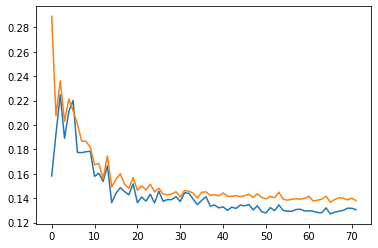

In [13]:
plt.plot(train_losses_1)
plt.plot(val_losses_1)

Both the validation and the training errors are similar but reasonably large and hence this would suggest we have a high bias problem.

## The Neural Net 2

Our second nerual net will try to address the high bias problem we have in the previous problem. Since we can't change the data we have been given, we will instead see if adding more nodes in the neural net reduces the error. We will add a regularisor to avoid over fitting.

We will build a neural net with multiple hidden layers, each with relu activation.

In [14]:
# Build the first NN with keras
model_2 = keras.Sequential([
    keras.Input(shape = (9,)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(1e-5)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(1e-5)),
    keras.layers.Dense(1,
                       activation = 'sigmoid',
                       activity_regularizer=keras.regularizers.l2(1e-5))
])

# compile the NN
model_2.compile(optimizer = 'adam',
               loss = 'mean_squared_error',
               metrics = ['accuracy'])

# fit the model to the data
model_2.fit(X_train, y_train, epochs = 70, validation_data = (X_val,y_val))

Epoch 1/70
23/23 [==============================] - 0s 7ms/step - loss: 0.2341 - accuracy: 0.6381 - val_loss: 0.2270 - val_accuracy: 0.7022
Epoch 2/70
23/23 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.7658 - val_loss: 0.2081 - val_accuracy: 0.7921
Epoch 3/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.8008 - val_loss: 0.1909 - val_accuracy: 0.7978
Epoch 4/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.8079 - val_loss: 0.1772 - val_accuracy: 0.7978
Epoch 5/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1667 - accuracy: 0.8079 - val_loss: 0.1668 - val_accuracy: 0.7978
Epoch 6/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1584 - accuracy: 0.8093 - val_loss: 0.1596 - val_accuracy: 0.8034
Epoch 7/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1523 - accuracy: 0.8121 - val_loss: 0.1544 - val_accuracy: 0.8034
Epoch 8/70
23/23 [==

23/23 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.8275 - val_loss: 0.1355 - val_accuracy: 0.8034
Epoch 60/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.8261 - val_loss: 0.1358 - val_accuracy: 0.8090
Epoch 61/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1283 - accuracy: 0.8317 - val_loss: 0.1356 - val_accuracy: 0.7921
Epoch 62/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.8261 - val_loss: 0.1351 - val_accuracy: 0.8090
Epoch 63/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.8303 - val_loss: 0.1363 - val_accuracy: 0.8034
Epoch 64/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1282 - accuracy: 0.8275 - val_loss: 0.1355 - val_accuracy: 0.8034
Epoch 65/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1282 - accuracy: 0.8317 - val_loss: 0.1355 - val_accuracy: 0.8090
Epoch 66/70
23/23 [======

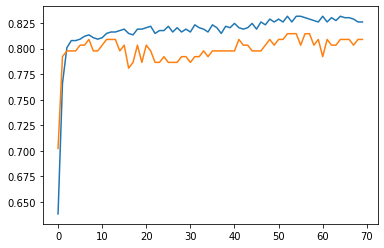

In [15]:
# Plot the accuracy
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])

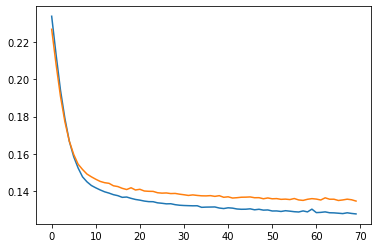

In [16]:
# Plot the loss
plt.plot(model_2.history.history['loss'])
plt.plot(model_2.history.history['val_loss'])

In [17]:
val_losses = []
train_losses = []
for i in range(1,len(X_train)+1,10):
    # Build the first NN with keras
    model_2 = keras.Sequential([
        keras.Input(shape = (9,)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.Dense(1,
                           activation = 'sigmoid',
                           activity_regularizer=keras.regularizers.l2(1e-5))
    ])

    # compile the NN
    model_2.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['accuracy'])

    # fit the model to the data
    model_2.fit(X_train[:i], y_train[:i], epochs = 70)
    val_losses.append(model_2.evaluate(X_val,y_val)[0])
    train_losses.append(model_2.evaluate(X_train[:i],y_train[:i])[0])

Epoch 1/70
1/1 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 1.0000
Epoch 2/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 1.0000
Epoch 3/70
1/1 [==============================] - 0s 999us/step - loss: 0.2070 - accuracy: 1.0000
Epoch 4/70
1/1 [==============================] - 0s 2ms/step - loss: 0.2032 - accuracy: 1.0000
Epoch 5/70
1/1 [==============================] - 0s 1ms/step - loss: 0.1994 - accuracy: 1.0000
Epoch 6/70
1/1 [==============================] - 0s 1ms/step - loss: 0.1958 - accuracy: 1.0000
Epoch 7/70
1/1 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 1.0000
Epoch 8/70
1/1 [==============================] - 0s 1ms/step - loss: 0.1887 - accuracy: 1.0000
Epoch 9/70
1/1 [==============================] - 0s 1ms/step - loss: 0.1852 - accuracy: 1.0000
Epoch 10/70
1/1 [==============================] - 0s 1ms/step - loss: 0.1817 - accuracy: 1.0000
Epoch 11/70
1/1 [====================

1/1 [==============================] - 0s 999us/step - loss: 0.2374 - accuracy: 0.8182
Epoch 14/70
1/1 [==============================] - 0s 999us/step - loss: 0.2367 - accuracy: 0.8182
Epoch 15/70
1/1 [==============================] - 0s 998us/step - loss: 0.2360 - accuracy: 0.8182
Epoch 16/70
1/1 [==============================] - 0s 991us/step - loss: 0.2353 - accuracy: 0.8182
Epoch 17/70
1/1 [==============================] - 0s 999us/step - loss: 0.2346 - accuracy: 0.8182
Epoch 18/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2338 - accuracy: 0.8182
Epoch 19/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2331 - accuracy: 0.8182
Epoch 20/70
1/1 [==============================] - 0s 999us/step - loss: 0.2324 - accuracy: 0.8182
Epoch 21/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2318 - accuracy: 0.8182
Epoch 22/70
1/1 [==============================] - 0s 999us/step - loss: 0.2312 - accuracy: 0.8182
Epoch 23/70
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.6190
Epoch 25/70
1/1 [==============================] - 0s 997us/step - loss: 0.2185 - accuracy: 0.6190
Epoch 26/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2169 - accuracy: 0.6667
Epoch 27/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2153 - accuracy: 0.7143
Epoch 28/70
1/1 [==============================] - 0s 999us/step - loss: 0.2138 - accuracy: 0.7143
Epoch 29/70
1/1 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.7143
Epoch 30/70
1/1 [==============================] - 0s 998us/step - loss: 0.2107 - accuracy: 0.7143
Epoch 31/70
1/1 [==============================] - 0s 998us/step - loss: 0.2092 - accuracy: 0.7143
Epoch 32/70
1/1 [==============================] - 0s 999us/step - loss: 0.2078 - accuracy: 0.7143
Epoch 33/70
1/1 [==============================] - 0s 999us/step - loss: 0.2064 - accuracy: 0.7619
Epoch 34/70
1/1 [=============

Epoch 36/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2093 - accuracy: 0.6774
Epoch 37/70
1/1 [==============================] - 0s 999us/step - loss: 0.2080 - accuracy: 0.6774
Epoch 38/70
1/1 [==============================] - 0s 3ms/step - loss: 0.2068 - accuracy: 0.6774
Epoch 39/70
1/1 [==============================] - 0s 998us/step - loss: 0.2056 - accuracy: 0.6774
Epoch 40/70
1/1 [==============================] - 0s 999us/step - loss: 0.2043 - accuracy: 0.6774
Epoch 41/70
1/1 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.6774
Epoch 42/70
1/1 [==============================] - 0s 0s/step - loss: 0.2018 - accuracy: 0.6774
Epoch 43/70
1/1 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.6774
Epoch 44/70
1/1 [==============================] - 0s 1ms/step - loss: 0.1993 - accuracy: 0.6774
Epoch 45/70
1/1 [==============================] - 0s 997us/step - loss: 0.1981 - accuracy: 0.6774
Epoch 46/70
1/1 [======

2/2 [==============================] - 0s 1ms/step - loss: 0.1835 - accuracy: 0.8293
Epoch 49/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1818 - accuracy: 0.8293
Epoch 50/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 0.8293
Epoch 51/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1778 - accuracy: 0.8293
Epoch 52/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1762 - accuracy: 0.8293
Epoch 53/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1742 - accuracy: 0.8293
Epoch 54/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.8293
Epoch 55/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.8293
Epoch 56/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1689 - accuracy: 0.8293
Epoch 57/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1670 - accuracy: 0.8293
Epoch 58/70
2/2 [=========================

2/2 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.8431
Epoch 61/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1309 - accuracy: 0.8431
Epoch 62/70
2/2 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8431
Epoch 63/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.8431
Epoch 64/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.8431
Epoch 65/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1278 - accuracy: 0.8431
Epoch 66/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.8431
Epoch 67/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.8431
Epoch 68/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.8431
Epoch 69/70
2/2 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.8431
Epoch 70/70
2/2 [=========================

2/2 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8525
Epoch 1/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.7324
Epoch 2/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2202 - accuracy: 0.7324
Epoch 3/70
3/3 [==============================] - 0s 1ms/step - loss: 0.2178 - accuracy: 0.7324
Epoch 4/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2156 - accuracy: 0.7324
Epoch 5/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.7183
Epoch 6/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.7324
Epoch 7/70
3/3 [==============================] - 0s 1ms/step - loss: 0.2091 - accuracy: 0.7324
Epoch 8/70
3/3 [==============================] - 0s 1ms/step - loss: 0.2071 - accuracy: 0.7324
Epoch 9/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2050 - accuracy: 0.7324
Epoch 10/70
3/3 [==============================] - 

3/3 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.6049
Epoch 13/70
3/3 [==============================] - 0s 1ms/step - loss: 0.2389 - accuracy: 0.6173
Epoch 14/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.6420
Epoch 15/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2352 - accuracy: 0.7284
Epoch 16/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.7160
Epoch 17/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 0.7160
Epoch 18/70
3/3 [==============================] - 0s 1ms/step - loss: 0.2295 - accuracy: 0.7160
Epoch 19/70
3/3 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.65 - 0s 2ms/step - loss: 0.2274 - accuracy: 0.7160
Epoch 20/70
3/3 [==============================] - 0s 1ms/step - loss: 0.2254 - accuracy: 0.7284
Epoch 21/70
3/3 [==============================] - 0s 2ms/step - loss: 0.2233 - accuracy: 0.7407


3/3 [==============================] - 0s 1ms/step - loss: 0.1889 - accuracy: 0.7692
Epoch 25/70
3/3 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.7802
Epoch 26/70
3/3 [==============================] - 0s 1ms/step - loss: 0.1849 - accuracy: 0.7912
Epoch 27/70
3/3 [==============================] - 0s 2ms/step - loss: 0.1829 - accuracy: 0.7912
Epoch 28/70
3/3 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.8132
Epoch 29/70
3/3 [==============================] - 0s 1ms/step - loss: 0.1790 - accuracy: 0.8242
Epoch 30/70
3/3 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.8242
Epoch 31/70
3/3 [==============================] - 0s 2ms/step - loss: 0.1754 - accuracy: 0.8132
Epoch 32/70
3/3 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.8242
Epoch 33/70
3/3 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.8352
Epoch 34/70
3/3 [=========================

4/4 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.8119
Epoch 36/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.8119
Epoch 37/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1539 - accuracy: 0.8119
Epoch 38/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1527 - accuracy: 0.8119
Epoch 39/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1514 - accuracy: 0.8119
Epoch 40/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1502 - accuracy: 0.8119
Epoch 41/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1490 - accuracy: 0.8119
Epoch 42/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1481 - accuracy: 0.8119
Epoch 43/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.8119
Epoch 44/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1461 - accuracy: 0.8119
Epoch 45/70
4/4 [=========================

4/4 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.8198
Epoch 48/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1346 - accuracy: 0.8198
Epoch 49/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1343 - accuracy: 0.8198
Epoch 50/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.8198
Epoch 51/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.8198
Epoch 52/70
4/4 [==============================] - 0s 2ms/step - loss: 0.1330 - accuracy: 0.8198
Epoch 53/70
4/4 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.8198
Epoch 54/70
4/4 [==============================] - 0s 1000us/step - loss: 0.1323 - accuracy: 0.8198
Epoch 55/70
4/4 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.78 - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8198
Epoch 56/70
4/4 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.81

4/4 [==============================] - 0s 1ms/step - loss: 0.1325 - accuracy: 0.8182
Epoch 60/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1321 - accuracy: 0.8182
Epoch 61/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8182
Epoch 62/70
4/4 [==============================] - 0s 2ms/step - loss: 0.1316 - accuracy: 0.8182
Epoch 63/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.8182
Epoch 64/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.8264
Epoch 65/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1308 - accuracy: 0.8264
Epoch 66/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.8264
Epoch 67/70
4/4 [==============================] - 0s 2ms/step - loss: 0.1303 - accuracy: 0.8264
Epoch 68/70
4/4 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8347
Epoch 69/70
4/4 [=========================

5/5 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8168
Epoch 1/70
5/5 [==============================] - 0s 1ms/step - loss: 0.2385 - accuracy: 0.6525
Epoch 2/70
5/5 [==============================] - 0s 1ms/step - loss: 0.2305 - accuracy: 0.7163
Epoch 3/70
5/5 [==============================] - 0s 1ms/step - loss: 0.2233 - accuracy: 0.7660
Epoch 4/70
5/5 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.7801
Epoch 5/70
5/5 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.7801
Epoch 6/70
5/5 [==============================] - 0s 1ms/step - loss: 0.2054 - accuracy: 0.7872
Epoch 7/70
5/5 [==============================] - 0s 1ms/step - loss: 0.2012 - accuracy: 0.7943
Epoch 8/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1969 - accuracy: 0.7943
Epoch 9/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1919 - accuracy: 0.7943
Epoch 10/70
5/5 [==============================] - 

Epoch 13/70
5/5 [==============================] - 0s 2ms/step - loss: 0.2040 - accuracy: 0.7748
Epoch 14/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1998 - accuracy: 0.7748
Epoch 15/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1957 - accuracy: 0.7748
Epoch 16/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1922 - accuracy: 0.7748
Epoch 17/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1888 - accuracy: 0.7748
Epoch 18/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1856 - accuracy: 0.7748
Epoch 19/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1825 - accuracy: 0.7748
Epoch 20/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1796 - accuracy: 0.7881
Epoch 21/70
5/5 [==============================] - 0s 2ms/step - loss: 0.1766 - accuracy: 0.8013
Epoch 22/70
5/5 [==============================] - 0s 1ms/step - loss: 0.1738 - accuracy: 0.8212
Epoch 23/70
5/5 [=============

6/6 [==============================] - 0s 1ms/step - loss: 0.1777 - accuracy: 0.7888
Epoch 26/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1756 - accuracy: 0.8012
Epoch 27/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1724 - accuracy: 0.8075
Epoch 28/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1699 - accuracy: 0.8075
Epoch 29/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1672 - accuracy: 0.8137
Epoch 30/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1649 - accuracy: 0.8137
Epoch 31/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1633 - accuracy: 0.8137
Epoch 32/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1627 - accuracy: 0.8075
Epoch 33/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1618 - accuracy: 0.8075
Epoch 34/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1602 - accuracy: 0.8075
Epoch 35/70
6/6 [=========================

6/6 [==============================] - 0s 1ms/step - loss: 0.1431 - accuracy: 0.7953
Epoch 38/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.7953
Epoch 39/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.7953
Epoch 40/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1415 - accuracy: 0.7953
Epoch 41/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.7953
Epoch 42/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1404 - accuracy: 0.7953
Epoch 43/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.7953
Epoch 44/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1397 - accuracy: 0.7953
Epoch 45/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.7953
Epoch 46/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.7953
Epoch 47/70
6/6 [=========================

6/6 [==============================] - 0s 1ms/step - loss: 0.1425 - accuracy: 0.8011
Epoch 50/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.8011
Epoch 51/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1410 - accuracy: 0.8011
Epoch 52/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1405 - accuracy: 0.8011
Epoch 53/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1398 - accuracy: 0.8011
Epoch 54/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.8011
Epoch 55/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.8011
Epoch 56/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1381 - accuracy: 0.8066
Epoch 57/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1380 - accuracy: 0.8066
Epoch 58/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.8066
Epoch 59/70
6/6 [=========================

6/6 [==============================] - 0s 2ms/step - loss: 0.1351 - accuracy: 0.8115
Epoch 62/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.8115
Epoch 63/70
6/6 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.8168
Epoch 64/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.8168
Epoch 65/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1340 - accuracy: 0.8168
Epoch 66/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.8168
Epoch 67/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.8168
Epoch 68/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.8168
Epoch 69/70
6/6 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.8168
Epoch 70/70
6/6 [==============================] - 0s 1ms/step - loss: 0.1323 - accuracy: 0.8168
Epoch 1/70
7/7 [==========================

7/7 [==============================] - 0s 1ms/step - loss: 0.2619 - accuracy: 0.4360
Epoch 3/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2538 - accuracy: 0.5640
Epoch 4/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2443 - accuracy: 0.5403
Epoch 5/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2367 - accuracy: 0.5450
Epoch 6/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2304 - accuracy: 0.5498
Epoch 7/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2252 - accuracy: 0.6019
Epoch 8/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2204 - accuracy: 0.6730
Epoch 9/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.6967
Epoch 10/70
7/7 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.7014
Epoch 11/70
7/7 [==============================] - 0s 1ms/step - loss: 0.2092 - accuracy: 0.7014
Epoch 12/70
7/7 [==============================] 

7/7 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.8145
Epoch 15/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.8145
Epoch 16/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1613 - accuracy: 0.8009
Epoch 17/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.8009
Epoch 18/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1546 - accuracy: 0.8009
Epoch 19/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1522 - accuracy: 0.8009
Epoch 20/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1503 - accuracy: 0.8009
Epoch 21/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1482 - accuracy: 0.8009
Epoch 22/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1465 - accuracy: 0.8009
Epoch 23/70
7/7 [==============================] - 0s 1ms/step - loss: 0.1449 - accuracy: 0.8009
Epoch 24/70
7/7 [=========================

8/8 [==============================] - 0s 1ms/step - loss: 0.1583 - accuracy: 0.8268
Epoch 27/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.8268
Epoch 28/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1536 - accuracy: 0.8268
Epoch 29/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1515 - accuracy: 0.8268
Epoch 30/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1496 - accuracy: 0.8268
Epoch 31/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1477 - accuracy: 0.8225
Epoch 32/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.8225
Epoch 33/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1448 - accuracy: 0.8225
Epoch 34/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.8225
Epoch 35/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.8225
Epoch 36/70
8/8 [=========================

8/8 [==============================] - 0s 1ms/step - loss: 0.1403 - accuracy: 0.8174
Epoch 39/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1396 - accuracy: 0.8174
Epoch 40/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1391 - accuracy: 0.8174
Epoch 41/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1386 - accuracy: 0.8216
Epoch 42/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1382 - accuracy: 0.8216
Epoch 43/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1378 - accuracy: 0.8216
Epoch 44/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1374 - accuracy: 0.8216
Epoch 45/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8216
Epoch 46/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1365 - accuracy: 0.8257
Epoch 47/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1361 - accuracy: 0.8257
Epoch 48/70
8/8 [=========================

8/8 [==============================] - 0s 1ms/step - loss: 0.1323 - accuracy: 0.8406
Epoch 51/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.8406
Epoch 52/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1317 - accuracy: 0.8406
Epoch 53/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1315 - accuracy: 0.8406
Epoch 54/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1312 - accuracy: 0.8446
Epoch 55/70
8/8 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.81 - 0s 1ms/step - loss: 0.1311 - accuracy: 0.8367
Epoch 56/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1309 - accuracy: 0.8446
Epoch 57/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.8406
Epoch 58/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.8367
Epoch 59/70
8/8 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.8406


9/9 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.8199
Epoch 63/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1318 - accuracy: 0.8199
Epoch 64/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.8199
Epoch 65/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.8199
Epoch 66/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.8161
Epoch 67/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1307 - accuracy: 0.8276
Epoch 68/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.8276
Epoch 69/70
9/9 [==============================] - 0s 2ms/step - loss: 0.1304 - accuracy: 0.8276
Epoch 70/70
9/9 [==============================] - 0s 1ms/step - loss: 0.1301 - accuracy: 0.8276
Epoch 1/70
9/9 [==============================] - 0s 2ms/step - loss: 0.2542 - accuracy: 0.4465
Epoch 2/70
9/9 [===========================

9/9 [==============================] - 0s 2ms/step - loss: 0.2714 - accuracy: 0.4199
Epoch 3/70
9/9 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.5658
Epoch 4/70
9/9 [==============================] - 0s 2ms/step - loss: 0.2395 - accuracy: 0.5943
Epoch 5/70
9/9 [==============================] - 0s 2ms/step - loss: 0.2270 - accuracy: 0.6228
Epoch 6/70
9/9 [==============================] - 0s 1ms/step - loss: 0.2155 - accuracy: 0.7153
Epoch 7/70
9/9 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.7544
Epoch 8/70
9/9 [==============================] - 0s 1ms/step - loss: 0.1992 - accuracy: 0.7616
Epoch 9/70
9/9 [==============================] - 0s 1ms/step - loss: 0.1927 - accuracy: 0.7722
Epoch 10/70
9/9 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.7758
Epoch 11/70
9/9 [==============================] - 0s 1ms/step - loss: 0.1812 - accuracy: 0.8078
Epoch 12/70
9/9 [==============================] 

10/10 [==============================] - 0s 1ms/step - loss: 0.1603 - accuracy: 0.8041
Epoch 15/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1571 - accuracy: 0.8007
Epoch 16/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1548 - accuracy: 0.8041
Epoch 17/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1531 - accuracy: 0.8007
Epoch 18/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1512 - accuracy: 0.8007
Epoch 19/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1497 - accuracy: 0.8007
Epoch 20/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1487 - accuracy: 0.7973
Epoch 21/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.8076
Epoch 22/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1461 - accuracy: 0.8110
Epoch 23/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1447 - accuracy: 0.8110
Epoch 24/70
10/10 [===

10/10 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.7940
Epoch 26/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1512 - accuracy: 0.7973
Epoch 27/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1505 - accuracy: 0.8007
Epoch 28/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1490 - accuracy: 0.7973
Epoch 29/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1480 - accuracy: 0.7973
Epoch 30/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.8007
Epoch 31/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1461 - accuracy: 0.7973
Epoch 32/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1451 - accuracy: 0.7973
Epoch 33/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1445 - accuracy: 0.8007
Epoch 34/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1436 - accuracy: 0.8073
Epoch 35/70
10/10 [===

10/10 [==============================] - 0s 1ms/step - loss: 0.1426 - accuracy: 0.7942
Epoch 36/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1421 - accuracy: 0.7942
Epoch 37/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1416 - accuracy: 0.8135
Epoch 38/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1414 - accuracy: 0.8103
Epoch 39/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1409 - accuracy: 0.8167
Epoch 40/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1406 - accuracy: 0.8167
Epoch 41/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1402 - accuracy: 0.8199
Epoch 42/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.8135
Epoch 43/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1395 - accuracy: 0.8135
Epoch 44/70
10/10 [==============================] - 0s 1ms/step - loss: 0.1395 - accuracy: 0.8135
Epoch 45/70
10/10 [===

11/11 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.8131
Epoch 47/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1371 - accuracy: 0.8162
Epoch 48/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8131
Epoch 49/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1365 - accuracy: 0.8100
Epoch 50/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1368 - accuracy: 0.8193
Epoch 51/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1367 - accuracy: 0.8162
Epoch 52/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.8193
Epoch 53/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1361 - accuracy: 0.8193
Epoch 54/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1359 - accuracy: 0.8224
Epoch 55/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1359 - accuracy: 0.8224
Epoch 56/70
11/11 [===

11/11 [==============================] - 0s 1ms/step - loss: 0.1308 - accuracy: 0.8157
Epoch 58/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1305 - accuracy: 0.8187
Epoch 59/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.8187
Epoch 60/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.8187
Epoch 61/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1301 - accuracy: 0.8157
Epoch 62/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.8157
Epoch 63/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.8157
Epoch 64/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.8157
Epoch 65/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.8157
Epoch 66/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8157
Epoch 67/70
11/11 [===

11/11 [==============================] - 0s 1ms/step - loss: 0.1301 - accuracy: 0.8240
Epoch 69/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.8240
Epoch 70/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8240
Epoch 1/70
11/11 [==============================] - 0s 1ms/step - loss: 0.2441 - accuracy: 0.6325
Epoch 2/70
11/11 [==============================] - 0s 1ms/step - loss: 0.2313 - accuracy: 0.7863
Epoch 3/70
11/11 [==============================] - 0s 1ms/step - loss: 0.2201 - accuracy: 0.7892
Epoch 4/70
11/11 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.7977
Epoch 5/70
11/11 [==============================] - 0s 1ms/step - loss: 0.2007 - accuracy: 0.7949
Epoch 6/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1924 - accuracy: 0.7977
Epoch 7/70
11/11 [==============================] - 0s 1ms/step - loss: 0.1848 - accuracy: 0.8091
Epoch 8/70
11/11 [===========

12/12 [==============================] - 0s 1ms/step - loss: 0.2091 - accuracy: 0.7867
Epoch 8/70
12/12 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.7867
Epoch 9/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1950 - accuracy: 0.7867
Epoch 10/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.7867
Epoch 11/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1812 - accuracy: 0.7867
Epoch 12/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1752 - accuracy: 0.7867
Epoch 13/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1695 - accuracy: 0.7867
Epoch 14/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1642 - accuracy: 0.7867
Epoch 15/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1595 - accuracy: 0.7867
Epoch 16/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1563 - accuracy: 0.7867
Epoch 17/70
12/12 [=====

12/12 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.8086
Epoch 18/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.8086
Epoch 19/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.8113
Epoch 20/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.8113
Epoch 21/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1364 - accuracy: 0.8140
Epoch 22/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1359 - accuracy: 0.8167
Epoch 23/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.8140
Epoch 24/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1351 - accuracy: 0.8113
Epoch 25/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1351 - accuracy: 0.8140
Epoch 26/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1347 - accuracy: 0.8140
Epoch 27/70
12/12 [===

12/12 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.8189
Epoch 28/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.8215
Epoch 29/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1362 - accuracy: 0.8215
Epoch 30/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1358 - accuracy: 0.8215
Epoch 31/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1352 - accuracy: 0.8241
Epoch 32/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1346 - accuracy: 0.8215
Epoch 33/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.8241
Epoch 34/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.8136
Epoch 35/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.8110
Epoch 36/70
12/12 [==============================] - 0s 1ms/step - loss: 0.1330 - accuracy: 0.8215
Epoch 37/70
12/12 [===

13/13 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.8235
Epoch 39/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 0.8261
Epoch 40/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8235
Epoch 41/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8235
Epoch 42/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1293 - accuracy: 0.8210
Epoch 43/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1284 - accuracy: 0.8210
Epoch 44/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.8235
Epoch 45/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.8235
Epoch 46/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1282 - accuracy: 0.8210
Epoch 47/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1276 - accuracy: 0.8210
Epoch 48/70
13/13 [===

13/13 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8254
Epoch 49/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.8254
Epoch 50/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1255 - accuracy: 0.8229
Epoch 51/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1250 - accuracy: 0.8254
Epoch 52/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1252 - accuracy: 0.8254
Epoch 53/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8254
Epoch 54/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1248 - accuracy: 0.8254
Epoch 55/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.8254
Epoch 56/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.8229
Epoch 57/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1245 - accuracy: 0.8254
Epoch 58/70
13/13 [===

13/13 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8321
Epoch 60/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.8273
Epoch 61/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.8273
Epoch 62/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.8297
Epoch 63/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.8273
Epoch 64/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1253 - accuracy: 0.8273
Epoch 65/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.8273
Epoch 66/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8273
Epoch 67/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1253 - accuracy: 0.8297
Epoch 68/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8273
Epoch 69/70
13/13 [===

14/14 [==============================] - 0s 928us/step - loss: 0.1247 - accuracy: 0.8242
Epoch 1/70
14/14 [==============================] - 0s 1ms/step - loss: 0.2269 - accuracy: 0.6636
Epoch 2/70
14/14 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.7262
Epoch 3/70
14/14 [==============================] - 0s 1ms/step - loss: 0.2086 - accuracy: 0.7610
Epoch 4/70
14/14 [==============================] - 0s 1ms/step - loss: 0.2001 - accuracy: 0.7633
Epoch 5/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1913 - accuracy: 0.7749
Epoch 6/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 0.7912
Epoch 7/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1754 - accuracy: 0.7935
Epoch 8/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1678 - accuracy: 0.7935
Epoch 9/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1621 - accuracy: 0.7958
Epoch 10/70
14/14 [==========

14/14 [==============================] - 0s 1ms/step - loss: 0.1478 - accuracy: 0.8005
Epoch 10/70
14/14 [==============================] - 0s 999us/step - loss: 0.1459 - accuracy: 0.8027
Epoch 11/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1446 - accuracy: 0.8027
Epoch 12/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1434 - accuracy: 0.8005
Epoch 13/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1425 - accuracy: 0.8050
Epoch 14/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1414 - accuracy: 0.8073
Epoch 15/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.8073
Epoch 16/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1397 - accuracy: 0.8163
Epoch 17/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1391 - accuracy: 0.8141
Epoch 18/70
14/14 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.8141
Epoch 19/70
14/14 [=

15/15 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.8093
Epoch 21/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.8004
Epoch 22/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1374 - accuracy: 0.8093
Epoch 23/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1361 - accuracy: 0.8027
Epoch 24/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1355 - accuracy: 0.8049
Epoch 25/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1353 - accuracy: 0.8049
Epoch 26/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.8049
Epoch 27/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1347 - accuracy: 0.8093
Epoch 28/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1345 - accuracy: 0.8182
Epoch 29/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1340 - accuracy: 0.8160
Epoch 30/70
15/15 [===

15/15 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8200
Epoch 31/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8134
Epoch 32/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.8156
Epoch 33/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.8113
Epoch 34/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1312 - accuracy: 0.8113
Epoch 35/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1307 - accuracy: 0.8178
Epoch 36/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.8221
Epoch 37/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.8286
Epoch 38/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8286
Epoch 39/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1299 - accuracy: 0.8243
Epoch 40/70
15/15 [===

15/15 [==============================] - 0s 1ms/step - loss: 0.1269 - accuracy: 0.8259
Epoch 42/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1267 - accuracy: 0.8259
Epoch 43/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.8217
Epoch 44/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1263 - accuracy: 0.8195
Epoch 45/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1267 - accuracy: 0.8238
Epoch 46/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.8238
Epoch 47/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.8238
Epoch 48/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.8217
Epoch 49/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.8174
Epoch 50/70
15/15 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.8217
Epoch 51/70
15/15 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.8046
Epoch 52/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1330 - accuracy: 0.8087
Epoch 53/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.8129
Epoch 54/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.8129
Epoch 55/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1317 - accuracy: 0.8150
Epoch 56/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1322 - accuracy: 0.8067
Epoch 57/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1322 - accuracy: 0.8129
Epoch 58/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.8108
Epoch 59/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1317 - accuracy: 0.8170
Epoch 60/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1307 - accuracy: 0.8191
Epoch 61/70
16/16 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.1236 - accuracy: 0.8248
Epoch 63/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1227 - accuracy: 0.8269
Epoch 64/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1231 - accuracy: 0.8248
Epoch 65/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1225 - accuracy: 0.8289
Epoch 66/70
16/16 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.8248
Epoch 67/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1225 - accuracy: 0.8269
Epoch 68/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1229 - accuracy: 0.8228
Epoch 69/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1224 - accuracy: 0.8248
Epoch 70/70
16/16 [==============================] - 0s 936us/step - loss: 0.1219 - accuracy: 0.8289
Epoch 1/70
16/16 [==============================] - 0s 1ms/step - loss: 0.2432 - accuracy: 0.4810
Epoch 2/70
16/16 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.6125
Epoch 2/70
16/16 [==============================] - 0s 1ms/step - loss: 0.2261 - accuracy: 0.6204
Epoch 3/70
16/16 [==============================] - 0s 1ms/step - loss: 0.2161 - accuracy: 0.6282
Epoch 4/70
16/16 [==============================] - 0s 1ms/step - loss: 0.2064 - accuracy: 0.7006
Epoch 5/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1971 - accuracy: 0.7808
Epoch 6/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1884 - accuracy: 0.7926
Epoch 7/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 0.7926
Epoch 8/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1716 - accuracy: 0.7926
Epoch 9/70
16/16 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.7926
Epoch 10/70
16/16 [==============================] - 0s 1ms/step - loss: 0.1578 - accuracy: 0.7965
Epoch 11/70
16/16 [===========

17/17 [==============================] - 0s 1ms/step - loss: 0.1515 - accuracy: 0.8023
Epoch 13/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1482 - accuracy: 0.8004
Epoch 14/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1458 - accuracy: 0.7985
Epoch 15/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1435 - accuracy: 0.8004
Epoch 16/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1417 - accuracy: 0.8081
Epoch 17/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.8061
Epoch 18/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.8119
Epoch 19/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.8196
Epoch 20/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1363 - accuracy: 0.8157
Epoch 21/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1351 - accuracy: 0.8138
Epoch 22/70
17/17 [===

17/17 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.8117
Epoch 24/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1332 - accuracy: 0.8136
Epoch 25/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.8154
Epoch 26/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8192
Epoch 27/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1317 - accuracy: 0.8192
Epoch 28/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8192
Epoch 29/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.8230
Epoch 30/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1305 - accuracy: 0.8211
Epoch 31/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1301 - accuracy: 0.8211
Epoch 32/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1299 - accuracy: 0.8173
Epoch 33/70
17/17 [===

17/17 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8207
Epoch 35/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.8244
Epoch 36/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1295 - accuracy: 0.8262
Epoch 37/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8244
Epoch 38/70
17/17 [==============================] - 0s 2ms/step - loss: 0.1289 - accuracy: 0.8281
Epoch 39/70
17/17 [==============================] - 0s 2ms/step - loss: 0.1287 - accuracy: 0.8262
Epoch 40/70
17/17 [==============================] - 0s 2ms/step - loss: 0.1283 - accuracy: 0.8207
Epoch 41/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.8244
Epoch 42/70
17/17 [==============================] - 0s 1ms/step - loss: 0.1280 - accuracy: 0.8226
Epoch 43/70
17/17 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.8244
Epoch 44/70
17/17 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.8240
Epoch 46/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1289 - accuracy: 0.8221
Epoch 47/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1285 - accuracy: 0.8221
Epoch 48/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8221
Epoch 49/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8221
Epoch 50/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.8221
Epoch 51/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1276 - accuracy: 0.8240
Epoch 52/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8221
Epoch 53/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1272 - accuracy: 0.8221
Epoch 54/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1273 - accuracy: 0.8185
Epoch 55/70
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8324
Epoch 57/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1248 - accuracy: 0.8307
Epoch 58/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8307
Epoch 59/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1248 - accuracy: 0.8324
Epoch 60/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1248 - accuracy: 0.8307
Epoch 61/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.8289
Epoch 62/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.8289
Epoch 63/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1245 - accuracy: 0.8324
Epoch 64/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1245 - accuracy: 0.8307
Epoch 65/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1242 - accuracy: 0.8307
Epoch 66/70
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.1244 - accuracy: 0.8319
Epoch 68/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1241 - accuracy: 0.8336
Epoch 69/70
18/18 [==============================] - 0s 1ms/step - loss: 0.1241 - accuracy: 0.8319
Epoch 70/70
18/18 [==============================] - 0s 944us/step - loss: 0.1236 - accuracy: 0.8319
Epoch 1/70
19/19 [==============================] - 0s 1ms/step - loss: 0.2592 - accuracy: 0.4269
Epoch 2/70
19/19 [==============================] - 0s 1ms/step - loss: 0.2356 - accuracy: 0.7194
Epoch 3/70
19/19 [==============================] - 0s 1ms/step - loss: 0.2171 - accuracy: 0.8055
Epoch 4/70
19/19 [==============================] - 0s 1ms/step - loss: 0.2026 - accuracy: 0.7900
Epoch 5/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 0.7883
Epoch 6/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 0.8072
Epoch 7/70
19/19 [========

19/19 [==============================] - 0s 1ms/step - loss: 0.1795 - accuracy: 0.7310
Epoch 7/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1710 - accuracy: 0.8003
Epoch 8/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1635 - accuracy: 0.8088
Epoch 9/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1557 - accuracy: 0.8206
Epoch 10/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1496 - accuracy: 0.8139
Epoch 11/70
19/19 [==============================] - 0s 1000us/step - loss: 0.1443 - accuracy: 0.8173
Epoch 12/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.8122
Epoch 13/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1382 - accuracy: 0.8190
Epoch 14/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1364 - accuracy: 0.8223
Epoch 15/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.8206
Epoch 16/70
19/19 [===

19/19 [==============================] - 0s 1ms/step - loss: 0.1329 - accuracy: 0.8120
Epoch 17/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.8253
Epoch 18/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1311 - accuracy: 0.8203
Epoch 19/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.8253
Epoch 20/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1299 - accuracy: 0.8319
Epoch 21/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8319
Epoch 22/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1293 - accuracy: 0.8286
Epoch 23/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1285 - accuracy: 0.8319
Epoch 24/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1282 - accuracy: 0.8319
Epoch 25/70
19/19 [==============================] - 0s 1ms/step - loss: 0.1277 - accuracy: 0.8353
Epoch 26/70
19/19 [===

20/20 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.8232
Epoch 28/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8216
Epoch 29/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8282
Epoch 30/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1292 - accuracy: 0.8232
Epoch 31/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.8232
Epoch 32/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1286 - accuracy: 0.8249
Epoch 33/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1284 - accuracy: 0.8265
Epoch 34/70
20/20 [==============================] - 0s 999us/step - loss: 0.1284 - accuracy: 0.8249
Epoch 35/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8282
Epoch 36/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.8298
Epoch 37/70
20/20 [=

20/20 [==============================] - 0s 1ms/step - loss: 0.1262 - accuracy: 0.8277
Epoch 39/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1263 - accuracy: 0.8293
Epoch 40/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8325
Epoch 41/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1264 - accuracy: 0.8261
Epoch 42/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.8309
Epoch 43/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1266 - accuracy: 0.8245
Epoch 44/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1252 - accuracy: 0.8357
Epoch 45/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8374
Epoch 46/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.8374
Epoch 47/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1249 - accuracy: 0.8390
Epoch 48/70
20/20 [===

20/20 [==============================] - 0s 1ms/step - loss: 0.1238 - accuracy: 0.8288
Epoch 50/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1238 - accuracy: 0.8320
Epoch 51/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1236 - accuracy: 0.8352
Epoch 52/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1235 - accuracy: 0.8368
Epoch 53/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1233 - accuracy: 0.8304
Epoch 54/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.8368
Epoch 55/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1230 - accuracy: 0.8384
Epoch 56/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1228 - accuracy: 0.8352
Epoch 57/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1227 - accuracy: 0.8384
Epoch 58/70
20/20 [==============================] - 0s 1ms/step - loss: 0.1229 - accuracy: 0.8384
Epoch 59/70
20/20 [===

21/21 [==============================] - 0s 1ms/step - loss: 0.1261 - accuracy: 0.8300
Epoch 61/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.8190
Epoch 62/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.8222
Epoch 63/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1262 - accuracy: 0.8284
Epoch 64/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.8331
Epoch 65/70
21/21 [==============================] - 0s 952us/step - loss: 0.1259 - accuracy: 0.8331
Epoch 66/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.8300
Epoch 67/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.8378
Epoch 68/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1261 - accuracy: 0.8315
Epoch 69/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1253 - accuracy: 0.8300
Epoch 70/70
21/21 [=

21/21 [==============================] - 0s 1ms/step - loss: 0.1237 - accuracy: 0.8372
Epoch 1/70
21/21 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.7292
Epoch 2/70
21/21 [==============================] - 0s 1ms/step - loss: 0.2135 - accuracy: 0.8064
Epoch 3/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1938 - accuracy: 0.8079
Epoch 4/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1766 - accuracy: 0.8109
Epoch 5/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1623 - accuracy: 0.8094
Epoch 6/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1517 - accuracy: 0.8154
Epoch 7/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1444 - accuracy: 0.8185
Epoch 8/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.8124
Epoch 9/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.8169
Epoch 10/70
21/21 [============

21/21 [==============================] - 0s 1ms/step - loss: 0.1386 - accuracy: 0.7988
Epoch 11/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8137
Epoch 12/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.8122
Epoch 13/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.8212
Epoch 14/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1331 - accuracy: 0.8212
Epoch 15/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.8167
Epoch 16/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1316 - accuracy: 0.8212
Epoch 17/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8212
Epoch 18/70
21/21 [==============================] - 0s 999us/step - loss: 0.1307 - accuracy: 0.8227
Epoch 19/70
21/21 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.8227
Epoch 20/70
21/21 [=

22/22 [==============================] - 0s 1ms/step - loss: 0.1280 - accuracy: 0.8253
Epoch 22/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1275 - accuracy: 0.8297
Epoch 23/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1275 - accuracy: 0.8253
Epoch 24/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1273 - accuracy: 0.8238
Epoch 25/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.8267
Epoch 26/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1262 - accuracy: 0.8282
Epoch 27/70
22/22 [==============================] - 0s 999us/step - loss: 0.1263 - accuracy: 0.8253
Epoch 28/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.8267
Epoch 29/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1254 - accuracy: 0.8267
Epoch 30/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1254 - accuracy: 0.8370
Epoch 31/70
22/22 [=

22/22 [==============================] - 0s 1ms/step - loss: 0.1316 - accuracy: 0.8249
Epoch 33/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1315 - accuracy: 0.8220
Epoch 34/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.8263
Epoch 35/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1305 - accuracy: 0.8278
Epoch 36/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.8249
Epoch 37/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.8278
Epoch 38/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8292
Epoch 39/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.8278
Epoch 40/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1289 - accuracy: 0.8220
Epoch 41/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.8263
Epoch 42/70
22/22 [===

22/22 [==============================] - 0s 1ms/step - loss: 0.1264 - accuracy: 0.8288
Epoch 43/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1264 - accuracy: 0.8331
Epoch 44/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1265 - accuracy: 0.8288
Epoch 45/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1261 - accuracy: 0.8345
Epoch 46/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.8288
Epoch 47/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.8288
Epoch 48/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8331
Epoch 49/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8317
Epoch 50/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.8317
Epoch 51/70
22/22 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.8302
Epoch 52/70
22/22 [===

23/23 [==============================] - 0s 1ms/step - loss: 0.1230 - accuracy: 0.8368
Epoch 54/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1230 - accuracy: 0.8383
Epoch 55/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1227 - accuracy: 0.8383
Epoch 56/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1227 - accuracy: 0.8383
Epoch 57/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1228 - accuracy: 0.8368
Epoch 58/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1223 - accuracy: 0.8354
Epoch 59/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1225 - accuracy: 0.8411
Epoch 60/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1222 - accuracy: 0.8340
Epoch 61/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1220 - accuracy: 0.8397
Epoch 62/70
23/23 [==============================] - 0s 956us/step - loss: 0.1221 - accuracy: 0.8425
Epoch 63/70
23/23 [=

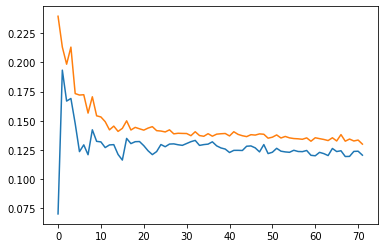

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)

We can figure out what the best regularization parameter is by running the code a few times with various values. The lowest validation value gives the best regularisation parameter value

In [19]:
eps = 1e-5
val_errors = []
while eps <= 1:
    # Build the first NN with keras
    model_2 = keras.Sequential([
        keras.Input(shape = (9,)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(eps)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(eps)),
        keras.layers.Dense(1,
                           activation = 'sigmoid',
                           activity_regularizer=keras.regularizers.l2(eps))
    ])

    # compile the NN
    model_2.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['accuracy'])

    # fit the model to the data
    model_2.fit(X_train, y_train, epochs = 70)
    val_errors.append(model_2.evaluate(X_val,y_val)[0])
    
    eps = eps*3

Epoch 1/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.6634
Epoch 2/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1851 - accuracy: 0.7868
Epoch 3/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1724 - accuracy: 0.7910
Epoch 4/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1624 - accuracy: 0.7910
Epoch 5/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1546 - accuracy: 0.7980
Epoch 6/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1494 - accuracy: 0.8163
Epoch 7/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1460 - accuracy: 0.8177
Epoch 8/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1434 - accuracy: 0.8093
Epoch 9/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1417 - accuracy: 0.8079
Epoch 10/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1402 - accuracy: 0.8149
Epoch 11/70
23/23 [

23/23 [==============================] - 0s 1ms/step - loss: 0.1394 - accuracy: 0.8107
Epoch 14/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.8149
Epoch 15/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1373 - accuracy: 0.8205
Epoch 16/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1367 - accuracy: 0.8219
Epoch 17/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1358 - accuracy: 0.8177
Epoch 18/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1352 - accuracy: 0.8163
Epoch 19/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1349 - accuracy: 0.8191
Epoch 20/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1344 - accuracy: 0.8205
Epoch 21/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.8191
Epoch 22/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1339 - accuracy: 0.8191
Epoch 23/70
23/23 [===

23/23 [==============================] - 0s 999us/step - loss: 0.1361 - accuracy: 0.8149
Epoch 26/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1353 - accuracy: 0.8205
Epoch 27/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.8191
Epoch 28/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.8149
Epoch 29/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1347 - accuracy: 0.8177
Epoch 30/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1344 - accuracy: 0.8205
Epoch 31/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1340 - accuracy: 0.8219
Epoch 32/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.8205
Epoch 33/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.8177
Epoch 34/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1344 - accuracy: 0.8135
Epoch 35/70
23/23 [=

23/23 [==============================] - 0s 1ms/step - loss: 0.1331 - accuracy: 0.8191
Epoch 37/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1330 - accuracy: 0.8205
Epoch 38/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.8219
Epoch 39/70
23/23 [==============================] - 0s 999us/step - loss: 0.1330 - accuracy: 0.8191
Epoch 40/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.8135
Epoch 41/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1322 - accuracy: 0.8219
Epoch 42/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1328 - accuracy: 0.8191
Epoch 43/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.8177
Epoch 44/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8261
Epoch 45/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1315 - accuracy: 0.8261
Epoch 46/70
23/23 [=

23/23 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.8303
Epoch 49/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1331 - accuracy: 0.8317
Epoch 50/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1333 - accuracy: 0.8261
Epoch 51/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1329 - accuracy: 0.8247
Epoch 52/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.8303
Epoch 53/70
23/23 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.8233
Epoch 54/70
23/23 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.8247
Epoch 55/70
23/23 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.8331
Epoch 56/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1321 - accuracy: 0.8303
Epoch 57/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1321 - accuracy: 0.8289
Epoch 58/70
23/23 [===

23/23 [==============================] - 0s 1ms/step - loss: 0.1339 - accuracy: 0.8275
Epoch 61/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.8289
Epoch 62/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.8289
Epoch 63/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.8275
Epoch 64/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1336 - accuracy: 0.8247
Epoch 65/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1336 - accuracy: 0.8275
Epoch 66/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1332 - accuracy: 0.8303
Epoch 67/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1332 - accuracy: 0.8261
Epoch 68/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1328 - accuracy: 0.8289
Epoch 69/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1325 - accuracy: 0.8289
Epoch 70/70
6/6 [=====

6/6 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.8090
Epoch 1/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2558 - accuracy: 0.6438
Epoch 2/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2406 - accuracy: 0.7377
Epoch 3/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.7938
Epoch 4/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2160 - accuracy: 0.7938
Epoch 5/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2055 - accuracy: 0.7924
Epoch 6/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1975 - accuracy: 0.7938
Epoch 7/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1919 - accuracy: 0.7924
Epoch 8/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1873 - accuracy: 0.7952
Epoch 9/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1838 - accuracy: 0.7994
Epoch 10/70
23/23 [==============

23/23 [==============================] - 0s 1ms/step - loss: 0.2163 - accuracy: 0.7924
Epoch 12/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2119 - accuracy: 0.7924
Epoch 13/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.7924
Epoch 14/70
23/23 [==============================] - 0s 999us/step - loss: 0.2050 - accuracy: 0.7980
Epoch 15/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.8107
Epoch 16/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1996 - accuracy: 0.8065
Epoch 17/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1971 - accuracy: 0.7952
Epoch 18/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1952 - accuracy: 0.8093
Epoch 19/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1932 - accuracy: 0.8121
Epoch 20/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1915 - accuracy: 0.8121
Epoch 21/70
23/23 [=

23/23 [==============================] - 0s 1ms/step - loss: 0.2396 - accuracy: 0.6297
Epoch 24/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2384 - accuracy: 0.6297
Epoch 25/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2370 - accuracy: 0.6297
Epoch 26/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.6297
Epoch 27/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2348 - accuracy: 0.6297
Epoch 28/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.6297
Epoch 29/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2325 - accuracy: 0.6297
Epoch 30/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2314 - accuracy: 0.6297
Epoch 31/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2301 - accuracy: 0.6297
Epoch 32/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2291 - accuracy: 0.6297
Epoch 33/70
23/23 [===

23/23 [==============================] - 0s 1ms/step - loss: 0.3020 - accuracy: 0.6297
Epoch 36/70
23/23 [==============================] - 0s 1ms/step - loss: 0.3006 - accuracy: 0.6297
Epoch 37/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2994 - accuracy: 0.6297
Epoch 38/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2981 - accuracy: 0.6297
Epoch 39/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2971 - accuracy: 0.6297
Epoch 40/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2960 - accuracy: 0.6297
Epoch 41/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2949 - accuracy: 0.6297
Epoch 42/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2939 - accuracy: 0.6297
Epoch 43/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2930 - accuracy: 0.6297
Epoch 44/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2922 - accuracy: 0.6297
Epoch 45/70
23/23 [===

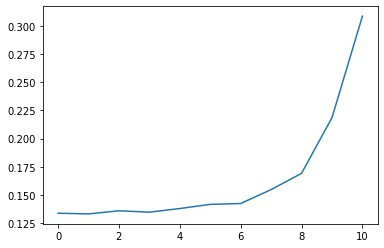

In [20]:
plt.plot(val_errors)

We see that small values of regularisation parameter are optimal with an ideal value around 3e-4. This still suggests that we may have a high bias problem.

In [21]:
# Build the first NN with keras
model_2 = keras.Sequential([
    keras.Input(shape = (9,)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(3e-4)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(3e-4)),
    keras.layers.Dense(1,
                       activation = 'sigmoid',
                       activity_regularizer=keras.regularizers.l2(3e-4))
])

# compile the NN
model_2.compile(optimizer = 'adam',
               loss = 'mean_squared_error',
               metrics = ['accuracy'])

# fit the model to the data
model_2.fit(X_train, y_train, epochs = 70, validation_data = (X_val,y_val))

Epoch 1/70
23/23 [==============================] - 0s 6ms/step - loss: 0.2216 - accuracy: 0.6297 - val_loss: 0.2294 - val_accuracy: 0.5618
Epoch 2/70
23/23 [==============================] - 0s 3ms/step - loss: 0.2038 - accuracy: 0.6297 - val_loss: 0.2139 - val_accuracy: 0.5899
Epoch 3/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1904 - accuracy: 0.6886 - val_loss: 0.2019 - val_accuracy: 0.6292
Epoch 4/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.7111 - val_loss: 0.1917 - val_accuracy: 0.7472
Epoch 5/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1738 - accuracy: 0.7896 - val_loss: 0.1846 - val_accuracy: 0.7584
Epoch 6/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.8008 - val_loss: 0.1781 - val_accuracy: 0.7865
Epoch 7/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.7952 - val_loss: 0.1732 - val_accuracy: 0.7753
Epoch 8/70
23/23 [==

23/23 [==============================] - 0s 3ms/step - loss: 0.1301 - accuracy: 0.8275 - val_loss: 0.1364 - val_accuracy: 0.7978
Epoch 60/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1300 - accuracy: 0.8331 - val_loss: 0.1363 - val_accuracy: 0.7921
Epoch 61/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1299 - accuracy: 0.8373 - val_loss: 0.1361 - val_accuracy: 0.7921
Epoch 62/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1297 - accuracy: 0.8345 - val_loss: 0.1364 - val_accuracy: 0.7921
Epoch 63/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.8359 - val_loss: 0.1362 - val_accuracy: 0.7921
Epoch 64/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1297 - accuracy: 0.8303 - val_loss: 0.1363 - val_accuracy: 0.7865
Epoch 65/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1298 - accuracy: 0.8387 - val_loss: 0.1359 - val_accuracy: 0.8090
Epoch 66/70
23/23 [======

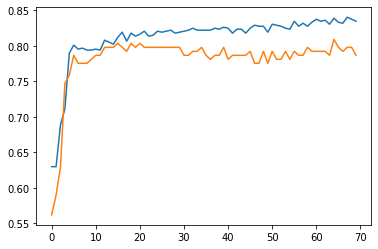

In [22]:
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])

## The Neural Net 3

We will include another layer and see if we can increase the accuracy. We will add another layer.

In [23]:
eps = 1e-5
val_errors = []
while eps <= 1:
    # Build the first NN with keras
    model_3 = keras.Sequential([
        keras.Input(shape = (9,)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(eps)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(eps)),
        keras.layers.Dense(15,
                           activation = 'relu',
                           activity_regularizer=keras.regularizers.l2(eps)),
        keras.layers.Dense(1,
                           activation = 'sigmoid',
                           activity_regularizer=keras.regularizers.l2(eps))
    ])

    # compile the NN
    model_3.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['accuracy'])

    # fit the model to the data
    model_3.fit(X_train, y_train, epochs = 70)
    val_errors.append(model_3.evaluate(X_val,y_val)[0])
    
    eps = eps*3

Epoch 1/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2678 - accuracy: 0.4151
Epoch 2/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2465 - accuracy: 0.6928
Epoch 3/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2375 - accuracy: 0.7069
Epoch 4/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.7181
Epoch 5/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2133 - accuracy: 0.7924
Epoch 6/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1944 - accuracy: 0.7910
Epoch 7/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 0.7910
Epoch 8/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1619 - accuracy: 0.7910
Epoch 9/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1511 - accuracy: 0.7910
Epoch 10/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1438 - accuracy: 0.8036
Epoch 11/70
23/23 [

23/23 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.8163
Epoch 14/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.8163
Epoch 15/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.8177
Epoch 16/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.8191
Epoch 17/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.8275
Epoch 18/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.8205
Epoch 19/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.8219
Epoch 20/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1307 - accuracy: 0.8247
Epoch 21/70
23/23 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.8261
Epoch 22/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1316 - accuracy: 0.8247
Epoch 23/70
23/23 [===

23/23 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8345
Epoch 26/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1284 - accuracy: 0.8317
Epoch 27/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.8275
Epoch 28/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1274 - accuracy: 0.8261
Epoch 29/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.8289
Epoch 30/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1275 - accuracy: 0.8303
Epoch 31/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.8303
Epoch 32/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1266 - accuracy: 0.8345
Epoch 33/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.8345
Epoch 34/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.8373
Epoch 35/70
23/23 [===

Epoch 35/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8317
Epoch 36/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1292 - accuracy: 0.8233
Epoch 37/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.8303
Epoch 38/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1292 - accuracy: 0.8359
Epoch 39/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1308 - accuracy: 0.8247
Epoch 40/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.8261
Epoch 41/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1286 - accuracy: 0.8331
Epoch 42/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1280 - accuracy: 0.8289
Epoch 43/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.8331
Epoch 44/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1277 - accuracy: 0.8345
Epoch 45/7

Epoch 47/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1274 - accuracy: 0.8317
Epoch 48/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1271 - accuracy: 0.8359
Epoch 49/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1270 - accuracy: 0.8373
Epoch 50/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1280 - accuracy: 0.8345
Epoch 51/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1271 - accuracy: 0.8331
Epoch 52/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1264 - accuracy: 0.8387
Epoch 53/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.8345
Epoch 54/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8387
Epoch 55/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8387
Epoch 56/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8303
Epoch 57/7

Epoch 59/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1265 - accuracy: 0.8457
Epoch 60/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1263 - accuracy: 0.8415
Epoch 61/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1263 - accuracy: 0.8387
Epoch 62/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1264 - accuracy: 0.8401
Epoch 63/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.8387
Epoch 64/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.8415
Epoch 65/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1261 - accuracy: 0.8387
Epoch 66/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.8443
Epoch 67/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1253 - accuracy: 0.8443
Epoch 68/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1254 - accuracy: 0.8415
Epoch 69/7

6/6 [==============================] - 0s 1ms/step - loss: 0.1447 - accuracy: 0.8034
Epoch 1/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2910 - accuracy: 0.4502
Epoch 2/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2676 - accuracy: 0.6788
Epoch 3/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2543 - accuracy: 0.7700
Epoch 4/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2427 - accuracy: 0.7826
Epoch 5/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2312 - accuracy: 0.7910
Epoch 6/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2206 - accuracy: 0.7980
Epoch 7/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2118 - accuracy: 0.8191
Epoch 8/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2040 - accuracy: 0.8135
Epoch 9/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1978 - accuracy: 0.8219
Epoch 10/70
23/23 [==============

23/23 [==============================] - 0s 1ms/step - loss: 0.2154 - accuracy: 0.7910
Epoch 13/70
23/23 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.7896
Epoch 14/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2074 - accuracy: 0.7910
Epoch 15/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2037 - accuracy: 0.7910
Epoch 16/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2005 - accuracy: 0.7980
Epoch 17/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1974 - accuracy: 0.8205
Epoch 18/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1946 - accuracy: 0.8233
Epoch 19/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1918 - accuracy: 0.8219
Epoch 20/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1890 - accuracy: 0.8289
Epoch 21/70
23/23 [==============================] - 0s 1ms/step - loss: 0.1867 - accuracy: 0.8275
Epoch 22/70
23/23 [===

23/23 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.6620
Epoch 25/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2258 - accuracy: 0.6676
Epoch 26/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2243 - accuracy: 0.7041
Epoch 27/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2229 - accuracy: 0.7377
Epoch 28/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2212 - accuracy: 0.7560
Epoch 29/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2196 - accuracy: 0.7630
Epoch 30/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2176 - accuracy: 0.7896
Epoch 31/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2163 - accuracy: 0.7938
Epoch 32/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2148 - accuracy: 0.7994
Epoch 33/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2138 - accuracy: 0.8022
Epoch 34/70
23/23 [===

23/23 [==============================] - 0s 2ms/step - loss: 0.2866 - accuracy: 0.6297
Epoch 37/70
23/23 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.6297
Epoch 38/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2844 - accuracy: 0.6297
Epoch 39/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2833 - accuracy: 0.6297
Epoch 40/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.6297
Epoch 41/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2813 - accuracy: 0.6297
Epoch 42/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2803 - accuracy: 0.6297
Epoch 43/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2794 - accuracy: 0.6297
Epoch 44/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2785 - accuracy: 0.6297
Epoch 45/70
23/23 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.6297
Epoch 46/70
23/23 [===

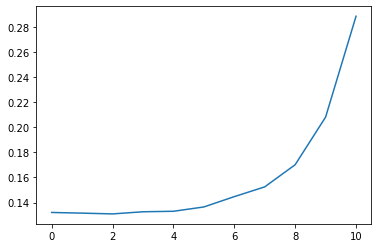

In [24]:
plt.plot(val_errors)

In [25]:
model_3 = keras.Sequential([
    keras.Input(shape = (9,)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(3e-5)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(3e-5)),
    keras.layers.Dense(15,
                       activation = 'relu',
                       activity_regularizer=keras.regularizers.l2(3e-5)),
    keras.layers.Dense(1,
                       activation = 'sigmoid',
                       activity_regularizer=keras.regularizers.l2(3e-5))
])

# compile the NN
model_3.compile(optimizer = 'adam',
               loss = 'mean_squared_error',
               metrics = ['accuracy'])

# fit the model to the data
model_3.fit(X_train, y_train, epochs = 70, validation_data=(X_val,y_val))

Epoch 1/70
23/23 [==============================] - 0s 8ms/step - loss: 0.2681 - accuracy: 0.3703 - val_loss: 0.2375 - val_accuracy: 0.4382
Epoch 2/70
23/23 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.6283 - val_loss: 0.2117 - val_accuracy: 0.7865
Epoch 3/70
23/23 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.8093 - val_loss: 0.1894 - val_accuracy: 0.7809
Epoch 4/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.8008 - val_loss: 0.1724 - val_accuracy: 0.7865
Epoch 5/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1657 - accuracy: 0.8022 - val_loss: 0.1588 - val_accuracy: 0.7865
Epoch 6/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.8036 - val_loss: 0.1500 - val_accuracy: 0.7865
Epoch 7/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1436 - accuracy: 0.8135 - val_loss: 0.1445 - val_accuracy: 0.7978
Epoch 8/70
23/23 [==

23/23 [==============================] - 0s 4ms/step - loss: 0.1264 - accuracy: 0.8317 - val_loss: 0.1346 - val_accuracy: 0.7978
Epoch 60/70
23/23 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.8373 - val_loss: 0.1342 - val_accuracy: 0.7921
Epoch 61/70
23/23 [==============================] - 0s 4ms/step - loss: 0.1258 - accuracy: 0.8387 - val_loss: 0.1350 - val_accuracy: 0.8090
Epoch 62/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1262 - accuracy: 0.8359 - val_loss: 0.1338 - val_accuracy: 0.7978
Epoch 63/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1261 - accuracy: 0.8401 - val_loss: 0.1341 - val_accuracy: 0.8034
Epoch 64/70
23/23 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.8387 - val_loss: 0.1344 - val_accuracy: 0.7921
Epoch 65/70
23/23 [==============================] - 0s 4ms/step - loss: 0.1254 - accuracy: 0.8373 - val_loss: 0.1339 - val_accuracy: 0.7978
Epoch 66/70
23/23 [======

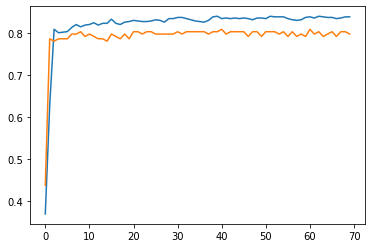

In [26]:
plt.plot(model_3.history.history['accuracy'])
plt.plot(model_3.history.history['val_accuracy'])

## Checking if more training helps

In [27]:
k = 0
val_acc_3 = []
while model_3.evaluate(X_val,y_val)[1]<0.95 and k<200:
    model_3.fit(X_train, y_train, epochs = 1)
    val_acc_3.append(model_3.evaluate(X_val,y_val)[1])
    k+=1

23/23 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.8359


6/6 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8202


6/6 [==============================] - 0s 1ms/step - loss: 0.1315 - accuracy: 0.8258


6/6 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.7921


6/6 [==============================] - 0s 2ms/step - loss: 0.1319 - accuracy: 0.8146


6/6 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.8202


6/6 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.8202


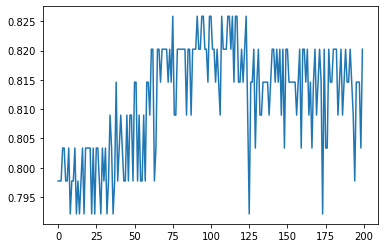

In [28]:
plt.plot(val_acc_3)

In [29]:
k = 0
val_acc_2 = []
while model_2.evaluate(X_val,y_val)[1]<0.95 and k <200:
    model_2.fit(X_train, y_train, epochs = 1)
    val_acc_2.append(model_2.evaluate(X_val,y_val)[1])
    k+=1

23/23 [==============================] - 0s 1ms/step - loss: 0.1269 - accuracy: 0.8485


6/6 [==============================] - 0s 1ms/step - loss: 0.1336 - accuracy: 0.7978


6/6 [==============================] - 0s 1ms/step - loss: 0.1323 - accuracy: 0.8034


6/6 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.8034


23/23 [==============================] - 0s 1ms/step - loss: 0.1210 - accuracy: 0.8457


6/6 [==============================] - 0s 999us/step - loss: 0.1306 - accuracy: 0.8090


6/6 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.8090


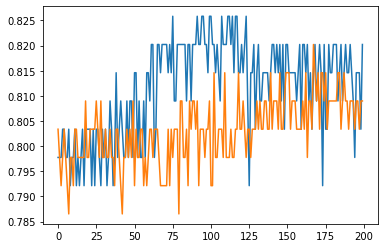

In [30]:
plt.plot(val_acc_3)
plt.plot(val_acc_2)

In [31]:
k = 0
val_acc_1 = []
while model_1.evaluate(X_val,y_val)[1]<0.95 and k <200:
    model_1.fit(X_train, y_train, epochs = 1)
    val_acc_1.append(model_1.evaluate(X_val,y_val)[1])
    k+=1

6/6 [==============================] - 0s 1ms/step - loss: 0.1355 - accuracy: 0.7865


6/6 [==============================] - 0s 999us/step - loss: 0.1336 - accuracy: 0.8090


6/6 [==============================] - 0s 999us/step - loss: 0.1331 - accuracy: 0.8034


23/23 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.8303


6/6 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.7921


23/23 [==============================] - 0s 1ms/step - loss: 0.1241 - accuracy: 0.8359


6/6 [==============================] - 0s 999us/step - loss: 0.1317 - accuracy: 0.7865


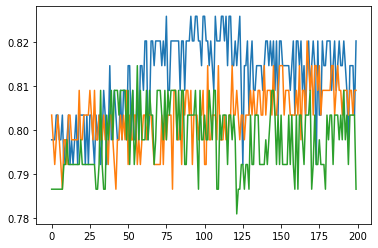

In [32]:
plt.plot(val_acc_3)
plt.plot(val_acc_2)
plt.plot(val_acc_1)

## Predictions

We will use our best NN to make predictions on an unlabelled test set. We have already loaded it and just need to run it with the predict_classes method of the neural net. While all of the neural nets seem relatively close in terms of performance, the first model appeared to be marginally the best so we shall select that one

In [33]:
y_test = (model_1.predict(X_test) > 0.5).astype("int32")
y_test

C:\Users\bassg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [34]:
y_test_list = []

for prediction in y_test:
    y_test_list.append(prediction[0])
    
y_test_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [35]:
predictions = pd.Series(data = y_test_list, index = X_test.index, name = 'Survived')
predictions = pd.concat([test_data_full.loc[:,'PassengerId'],predictions],axis = 1)
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [36]:
# predictions.to_csv('titanic_survivors_predictions.csv',index = False)